# Coursework 2: Robotic behavioural cloning from images and actuator data

## Description
For this coursework, you are required to develop a behaviour cloning model. Behaviour cloning is a technique for training robotic agents using a dataset of sequences of actions. Consider the supervised learning definition where we have a dataset of observatios $d=\{(x_{1},y_{1}),...,(x_{n},y_{n})\}$ and the aim is to learn a function: $f:\mathcal{X}\rightarrow\mathcal{Y}$. In this case, $\mathcal{X}$ is the set of "observations" that the robot makes and $\mathcal{Y}$ is the set of actions that the robot takes.

The dataset you have been provided with contains examples of robot arms being required to pickup objects or drop objects (given it has already picked the object up) in a specific place. The observation space ($\mathcal{X}$) consists of:
- "front_cam_ob": A 3rd person image of the scene 
- "mount_cam_ob": An image of the scene taken from a camera mounted on top of the robotic arm, looking down
- "ee_cartesian_pos_ob": The positional and orientation co-ordinates of the robotic arm
- "ee_cartesian_vel_ob": The velocity of position and orientation of the robotic arm
- "joint_pos_ob": The position of the gripper which opens and closes

The action space ($\mathcal{Y}$) consists of:
- Three co-ordinates defining how much to move the robotic arm
- An action defining whether to open, not to move or close the gripper

The dataset is split into "trajectories" i.e., sequences of:
- $x_{i}$: The front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob, joint_pos_ob __at time point i__ 
- $y_{i}$: The action taken i.e., how to move the arm and the gripper __given the observations__ in $x_{i}$

More information on the dataset can be found at: https://github.com/clvrai/clvr_jaco_play_dataset?tab=readme-ov-file

### Task
Your task has been split into several questions, each exploring how to develop an appropriate model for learning $f:\mathcal{X}\rightarrow\mathcal{Y}$. The task will require you to:
- Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions: You will be required to evaluate a proposed deep learning architecture (which takes as input all of front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob and predict the two actions) and propose a new model which outperforms the existing model;
- Question 2: Define and evaluate a VAE model for performing self-supervised learning and tune it as best you can, to learn a latent representation that can be used as input to a downstream supervised model for behaviour cloning
- Question 3: Evaluate the performance of your model proposed in question 1 against your self-supervised VAE representations from question 2 (plus a supervised head) on the test set

### Pointers
Some helper functions have been provided for you including the following functionality:
- A training and validation loop capabale of:
  - Handling "half-precision" modelling;
  - Logging results to weights and biases;
- An eda template to help you visualise the data
- An evaluation template to help you load saved model checkpoints from weights and biases
- A preprocessing script to help you convert the data into train/validation and test splits;
  - In this preprocessing script, trajectories longer than 75 timesteps have been removed to ease the computational requirements of the task;
- A torch Dataset class capable of handling the multi-model nature of the data;
- A example collate_fn to use in Dataloaders

Additionally, it is strongly suggested to call ```torch.manual_seed(1)``` whenever you initialise your model (i.e., when you first create the model or call model.reset()). This will ensure the parameters are initialised at the same value each time.

### IMPORTANT
- You are __not__ allowed to use pre-trained models, developed outside of this coursework i.e., you could __not__ use a pre-trained YOLO model
- Questions have been marked under the title "Task", ensure that you answer/address all of the bullet points under these headings


## Data download
Download the data for the project from here: https://drive.usercontent.google.com/download?id=1tVSilmXhyQd8gxZAEhvKMnynw0qzRFSZ&authuser=0

Save the data locally at: ../data/all_play_data_diverse or in Google Collab at: /content/drive/MyDrive/comp0188_2425/cw2. Saving the data in these locations will ensure the proprocessing script provided runs correctly. If you would like to alter these locations, you can alter them in the config.py file of the provided comp0188_cw2 package via the ROOT_PATH global variable.

### transition_df.csv
You have additionally been provided with a csv called "transition_df.csv". This contains a row for each observation/action pair in the dataset and is used to generate the train/validation and test datasets for this task. Note that this csv contains all trajectories (even those over 75 timesteps). This csv might also be useful for EDA. The transition_df.csv should be placed in the same folder that you placed the raw data in (discussed above).

## Imports

The comp0188_cw2 contains some config functionality so that you can run the code in collab and locally (to test models)! When you first import the package, import the project_options and set the appropriate configs.
- project_options.collab = True will set the dataset directories for google collab whilst false will set suitable local directories
- project_options.debug = True will load a subset of data whilst False will load all of the data. 

__IMPORTANT__: Alterting these options __once you have loaded other functionality__ from comp0188_cw2 may result in unintended outcomes.

In [2]:
# COLLAB = False
# if COLLAB:
#     !pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git
#     !pip install h5py
#     # !pip install wandb
#     !pip install torchinfo
#     !pip install jaxtyping
#     !pip install git+https://github.com/joshuaspear/comp0188_cw2_public.git
#     !pip install typeguard==2.13.3

In [3]:
# !pip install --force-reinstall git+ssh://git@github.com/joshuaspear/pymlrf.git
# !pip install --force-reinstall git+ssh://git@github.com/joshuaspear/pymlrf.git

# !pip install git+ssh://git@github.com/joshuaspear/comp0188_cw2_public.git
# !pip install torchinfo
# !pip install jaxtyping
# !pip install typeguard==2.13.3

Ignore the error: 
```ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.```

In [4]:
ROOT_PATH = "/cs/student/projects1/aibh/2024/gcosta/dlcw2/all_play_data_diverse"

In [5]:
from comp0188_cw2 import project_options
project_options.collab = False
print(project_options.collab)
project_options.debug = True
print(project_options.debug)

False
True


In [6]:
# Add sys path for pymlrf, otherwise import doesn't work.
import sys
sys.path.append('/cs/student/msc/aibh/2024/gcosta/Modules/pymlrf-master/src')

In [7]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import datetime
from pymlrf.Structs.torch import DatasetOutput
import copy

import pandas as pd
from comp0188_cw2.utils import load_all_files
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import datetime
from typing import List

from comp0188_cw2.config import (
    train_dh, val_dh, test_dh, WANDB_PROJECT
    )
from comp0188_cw2.models.CNNConfig import ConvolutionLayersConfig
from comp0188_cw2.models.base import BaseModel
from comp0188_cw2.models.JointCNNEncoder import JointCNNEncoder
from comp0188_cw2.models.CNN import CNN
from comp0188_cw2.models.MLP import MLP
from comp0188_cw2.Metric.WandBMetricOrchestrator import WandBMetricOrchestrator
from comp0188_cw2.Dataset.NpDictDataset import NpDictDataset
from comp0188_cw2.Loss.BalancedLoss import TrackerBalancedLoss
from comp0188_cw2 import logger
from comp0188_cw2.training.TrainingLoop import TorchTrainingLoop

from torchsummary import summary
import altair as alt

2024-12-24 00:57:04,042 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


In [8]:
print(train_dh.loc)

/cs/student/projects1/aibh/2024/gcosta/dlcw2/all_play_data_diverse/debug/train


## Build the dataset
You will only need to perform this step __once__ for the full dataset and __once__ for the debug dataset for the entire coursework, both locally and in Google collab. In Google Collab, the data will be saved in your Google Drive.

In [9]:
from comp0188_cw2.Preprocessing import main
RUN_PREPROCESSING = False
if RUN_PREPROCESSING:
  main()

## Question 1: Tune an end-to-end supervised learning model taking in the full set of observations and predicting actions

In [10]:
_keys = [
    "actions",
    "front_cam_ob",
    "mount_cam_ob",
    "terminals",
    "ee_cartesian_pos_ob",
    "ee_cartesian_vel_ob",
    "joint_pos_ob"
    ]
train_nps = load_all_files(train_dh.loc,"train_[0-9]+.h5",keys=_keys)
val_nps = load_all_files(val_dh.loc,"val_[0-9]+.h5",keys=_keys)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


In [11]:
train_nps["front_cam_ob"].shape

(1274, 224, 224)

### Question 1.a Preprocessing
Most likely in machine learning pipelines, input data needs to be preprocessed before passing it to the model. This question requires you to specify the preprocessing that you will perform for the different types of data i.e., front_cam_ob, mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob. The dataset class provided in the associated "comp0188_cw2" package enables you to pass a dictionary of functions to preprocess each element of the observations and actions. The class expects a dictionary of transformations to apply to each input/output. 

#### Question 1.a.i Preprocessing steps (5 marks)

##### Task
- Complete the dictionaries below, specifying the type of transformations you wish to perform. For each element (of the observations and actions), you should __at least__ convert the output to a tensor thus, these transformations have been implemented for you. You may alter __any__ part of the code between the "INSERT YOUR CODE HERE" comments

In [12]:
"""Exploring how H5 files work"""
descriptions = {
"front_cam_ob": 'A 3rd person image of the scene ',
"mount_cam_ob":' An image of the scene taken from a camera mounted on top of the robotic arm, looking down',
"ee_cartesian_pos_ob": 'The positional and orientation co-ordinates of the robotic arm',
"ee_cartesian_vel_ob": 'The velocity of position and orientation of the robotic arm',
"joint_pos_ob": 'The position of the gripper which opens and closes',
"actions": "Three co-ordinates defining how much to move the robotic arm. An action defining whether to open, not to move or close the gripper",
"terminals": "Gripper",
}

import h5py
import os

with h5py.File(os.path.join(train_dh.loc, 'train_0.h5'), 'r') as f:
    print("Groups and datasets:", list(f.keys()))
    
"""Data Shapes"""
data = []
for key in train_nps.keys():
    data.append({
        'Key': key,
        'Description': descriptions[key],
        'Shape': str(train_nps[key].shape),
        'Data Type': str(train_nps[key].dtype),
    })

df = pd.DataFrame(data)
pd.options.display.max_colwidth = 100
df

Groups and datasets: ['actions', 'ee_cartesian_pos_ob', 'ee_cartesian_vel_ob', 'front_cam_ob', 'joint_pos_ob', 'mount_cam_ob', 'terminals']


,Key,Description,Shape,Data Type
0,actions,Three co-ordinates defining how much to move the robotic arm. An action defining whether to open...,"(1274, 4)",float16
1,front_cam_ob,A 3rd person image of the scene,"(1274, 224, 224)",float16
2,mount_cam_ob,"An image of the scene taken from a camera mounted on top of the robotic arm, looking down","(1274, 224, 224)",float16
3,terminals,Gripper,"(1274,)",int64
4,ee_cartesian_pos_ob,The positional and orientation co-ordinates of the robotic arm,"(1274, 7)",float16
5,ee_cartesian_vel_ob,The velocity of position and orientation of the robotic arm,"(1274, 6)",float16
6,joint_pos_ob,The position of the gripper which opens and closes,"(1274, 2)",float16


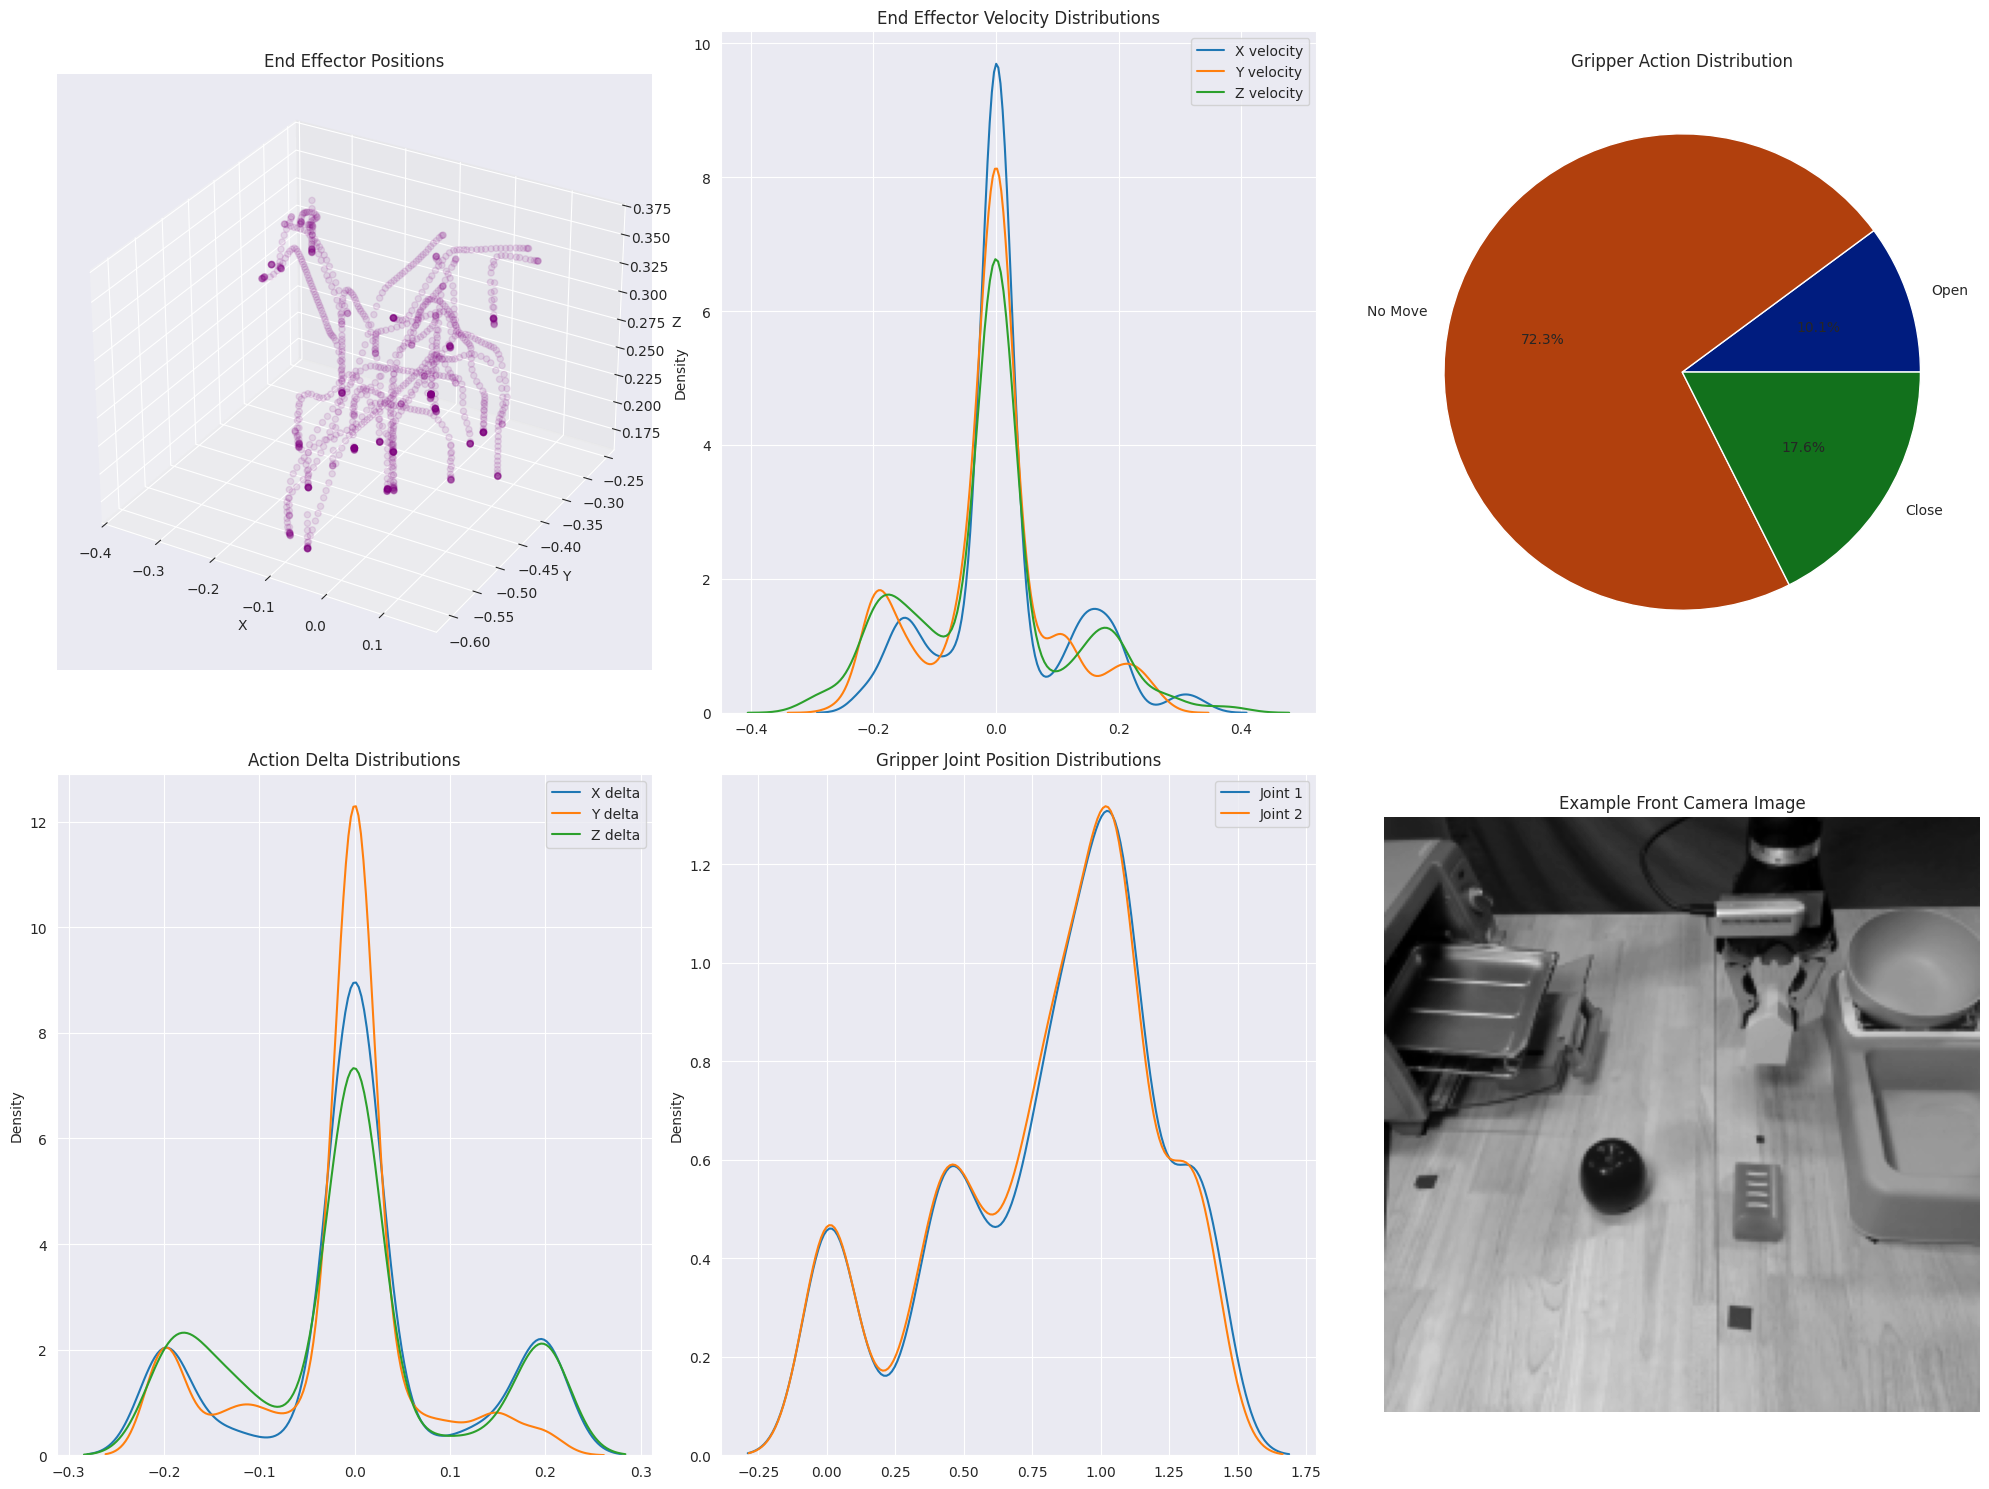

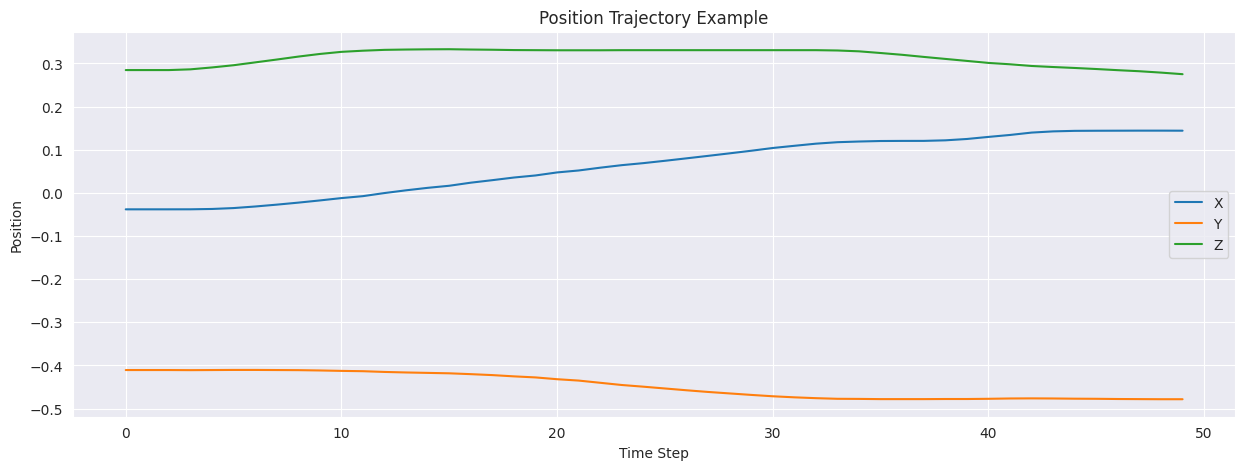

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
# Set up a large figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# 1. Cartesian Position Distribution (3D scatter plot)
ax1 = fig.add_subplot(231, projection='3d')
positions = train_nps['ee_cartesian_pos_ob'][:, 0:3]
ax1.scatter(positions[:, 0], positions[:, 1], positions[:, 2], alpha=0.1, color="purple")
ax1.set_title('End Effector Positions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# 2. Velocity Distribution
ax2 = fig.add_subplot(232)
velocities = train_nps['ee_cartesian_vel_ob'][:, 0:3]
for i, dim in enumerate(['X', 'Y', 'Z']):
    sns.kdeplot(velocities[:, i], label=f'{dim} velocity', ax=ax2)
ax2.set_title('End Effector Velocity Distributions')
ax2.legend()

# 3. Gripper Action Distribution (Pie Chart)
ax3 = fig.add_subplot(233)
gripper_actions = train_nps['actions'][:, 3]
unique, counts = np.unique(gripper_actions, return_counts=True)
# sns.
colors = sns.color_palette('dark')

ax3.pie(counts, labels=['Open', 'No Move', 'Close'], autopct='%1.1f%%', colors=colors)
ax3.set_title('Gripper Action Distribution')

# 4. Action Deltas Distribution
ax4 = fig.add_subplot(234)
deltas = train_nps['actions'][:, 0:3]
for i, dim in enumerate(['X', 'Y', 'Z']):
    sns.kdeplot(deltas[:, i], label=f'{dim} delta', ax=ax4)
ax4.set_title('Action Delta Distributions')
ax4.legend()

# 5. Joint Positions Distribution
ax5 = fig.add_subplot(235)
joint_pos = train_nps['joint_pos_ob'][:, -2:]  # Last two elements
sns.kdeplot(joint_pos[:, 0], label='Joint 1', ax=ax5)
sns.kdeplot(joint_pos[:, 1], label='Joint 2', ax=ax5)
ax5.set_title('Gripper Joint Position Distributions')
ax5.legend()

# 6. Example Images
ax6 = fig.add_subplot(236)
example_front = ((train_nps['front_cam_ob'][0] - train_nps['front_cam_ob'][0].min()) * 
                (255/(train_nps['front_cam_ob'][0].max() - train_nps['front_cam_ob'][0].min()))).astype('uint8')
ax6.imshow(example_front, cmap='gray')
ax6.set_title('Example Front Camera Image')
ax6.axis('off')

plt.tight_layout()
plt.show()

# Additional temporal analysis
plt.figure(figsize=(15, 5))
# Plot trajectory example - position over time for a single sequence
sequence_length = 50  # Adjust based on your data
plt.plot(positions[:sequence_length, 0], label='X')
plt.plot(positions[:sequence_length, 1], label='Y')
plt.plot(positions[:sequence_length, 2], label='Z')
plt.title('Position Trajectory Example')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()

float16
(224, 224)


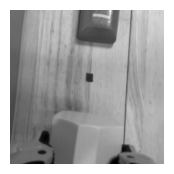

Shape: (224, 224)
Data type: float16
Value range: [21.15625, 226.875]


In [14]:
import matplotlib.pyplot as plt

for key in _keys:
    # if key == 'ee_cartesian_pos_ob':
    #     for action_idx in range(1000, 1010 ):
    #         print(train_nps[key][action_idx])    
    if key == 'actions':
        for action_idx in range(0, 1):
            print(train_nps[key][action_idx].dtype)
    if key == "mount_cam_ob":
        for image_idx in range(0, len(train_nps[key])):
            if image_idx < 1:
                img_array = train_nps[key][image_idx]
                print(img_array.shape)
                # img_array = ((img_array - img_array.min()) * (255/(img_array.max() - img_array.min()))).astype('uint8')
                plt.figure(figsize=(2,2))
                plt.imshow(img_array, cmap='gray') 
                plt.axis('off')
                plt.show()

                img_array = train_nps[key][image_idx]
                print(f"Shape: {img_array.shape}")
                print(f"Data type: {img_array.dtype}")
                print(f"Value range: [{img_array.min()}, {img_array.max()}]")                
                

In [15]:
# ******* INSERT YOUR CODE HERE *******
#TODO: Maybe dont change scaling of the Y coordinate.
def action_transform(x):
    # Standardize coordinates 
    movement = torch.tensor(
        (x[0:3] - train_nps['actions'][:,0:3].mean(axis=0)) / 
        train_nps['actions'][:,0:3].std(axis=0)
    )
    # Keep gripper as single integer value
    gripper = torch.tensor(int(x[3]), dtype=torch.long)  # Explicitly make it a long tensor for CrossEntropyLoss
    return torch.cat([movement, gripper.unsqueeze(0)])  # Keep 1D shape

"""Image means and stds"""
front_mean = (train_nps['front_cam_ob'].astype(np.float32) / 255.0).mean()
front_std = (train_nps['front_cam_ob'].astype(np.float32) / 255.0).std()
mount_mean = (train_nps['mount_cam_ob'].astype(np.float32) / 255.0).mean()
mount_std = (train_nps['mount_cam_ob'].astype(np.float32) / 255.0).std()

pos_tensor = torch.from_numpy(train_nps['ee_cartesian_pos_ob'])
vel_tensor = torch.from_numpy(train_nps['ee_cartesian_vel_ob'])
joint_tensor = torch.from_numpy(train_nps['joint_pos_ob'])


"""TRANSFORMS"""
global_transforms = {
    # IMAGE transforms - normalize to [0,1] and standardize
    "front_cam_ob": transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x / 255.0)),
        transforms.Normalize(
            mean=[float(front_mean)],  
            std=[float(front_std)]
        )
    ]),
    # IMAGE transforms - normalize to [0,1] and standardize
    "mount_cam_ob": transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x / 255.0)),        
        transforms.Normalize(
            mean=[float(mount_mean)],  
            std=[float(mount_std)]     
        )
    ]),
    # CONTINUOUS transforms
    "ee_cartesian_pos_ob": lambda x: (torch.tensor(x) - pos_tensor.mean(dim=0)) / pos_tensor.std(dim=0),
    # CONTINUOUS transforms
    "ee_cartesian_vel_ob": lambda x: (torch.tensor(x) - vel_tensor.mean(dim=0)) / vel_tensor.std(dim=0),
    # CONTINUOUS transforms values: Gripper joint positions standardization
    "joint_pos_ob": lambda x: (torch.tensor(x) - joint_tensor.mean(dim=0)) / joint_tensor.std(dim=0),
    # action gets special treatment.
    "actions": lambda x: action_transform(x)
}

#### Question 1.a.ii Justification (5 marks)
##### Task
- In the markdown cell below, justify your decisions for preprocessing including where you have decided __not__ to apply preprocessing. You should include empirical evidence from your EDA analysis to support your decisions. Justfication __without__ evidence will be rewarded 0 marks.

_actions_: **There are three potential actions our robot arm can take: Do Nothing: 0, Open Gripper: 1, Close Gripper: 2. An action is an array of 4 values, the first three being a coordinate to move to, and the last one the action [0-2]. Naturally, actions that have "Do Nothing" have a 0 coordinate. We don't need to One Hot Encode the [0-2] action as it is ordinal. But we should standardize the movement coordinates, as neural networks generally do better with standardized values. And we will also do the same for the other cartesian coordinates.**

_front_cam_ob_: **Our image data has already been preprocessed into 224x224 grayscale images thanks to Josh. So the only thing we need to do is normalize each pixel to 0-1. As well as converting it to a tensor.** 

_mount_cam_ob_: **Same as front_cam_ob, just normalize and convert to tensor.**

TODO: Should we normalize the quaternion?

_ee_cartesian_pos_ob_: **This data consists of 7 values. It uses (x,y,z) + (w,x,y,z) quaternion (7 values total). The quaternion is to avoid gimbal lock and is used in robotics a lot. Since these are continuous values we need to normalize and standardize them for the same reasons mentioned above.**

_ee_cartesian_vel_ob_: **This consists of 6 values: a position (x,y,z) and a rotation (yaw, roll, pitch). Also continuous, so let's standardize it.**

_joint_pos_ob_: **This is a 2D vector representing the position of the joint for the gripper. It can only move in a 2D plane. Let's also standardize it.**

### Question 1.b End-to-end supervised model evaluation
The code below defines an end to end supervised model which: 
- Jointly encodes the two images ("front_cam_ob", "mount_cam_ob") using a CNN architecture (image_encoder);
- Seperately encoding the positional and velocity observations using an MLP;
- Combines the two embeddings by adding them together and;
- Passes the combined embedding into a final MLP layer (dense)
  
This question requires you to define sutable loss functions for the model and then evaluate the performance.

In [16]:
cnn2_config = ConvolutionLayersConfig(
    input_dim=224,
    input_channels=2,
    layers=[
        nn.Conv2d(
            in_channels=2,
            out_channels=8,
            kernel_size=(3,3),
            stride=1,
            padding=1,
            dilation=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2))
        ]
    )

_cnn_output_dim = cnn2_config.get_output_dims()
_cnn_output_channels = cnn2_config.get_output_channels()
_mlp_input_dim = int(
            (_cnn_output_dim[-1]*_cnn_output_dim[-1])*_cnn_output_channels[-1]
            )


image_encoder = JointCNNEncoder(
    cnn=CNN(cnn2_config),
    dense=MLP(
        input_dim=_mlp_input_dim,
        hidden_dims=[256],
        output_dim=128
        )
)

obs_encoder = MLP(
    input_dim = 15,
    hidden_dims = [256,256],
    output_dim = 128
)

dense = MLP(
    input_dim = 128,
    hidden_dims = [64,32],
    output_dim = 6
)

class Baseline1(BaseModel):
  def __init__(
      self,
      image_encoder:JointCNNEncoder,
      obs_encoder:MLP,
      dense:MLP
      ) -> None:
      super().__init__()
      self.image_encoder = image_encoder
      self.obs_encoder = obs_encoder
      self.dense = dense

  def forward(self, images, obs):
    _img_enc = self.image_encoder(images)
    _obs_enc = self.obs_encoder(obs)
    _dense_enc = self.dense(_img_enc+_obs_enc)
    pos = _dense_enc[:,0:3]
    grp = _dense_enc[:,3:]
    return {
        "pos": pos,
        "grp":grp
        }
  def reset(
      self,
      image_encoder_kwargs,
      obs_encoder_kwargs,
      dense_kwargs
      ):
    self.image_encoder.reset(**image_encoder_kwargs)
    self.obs_encoder.reset(**obs_encoder_kwargs)
    self.dense.reset(**dense_kwargs)

torch.manual_seed(1)
model = Baseline1(
    image_encoder=image_encoder,
    obs_encoder=obs_encoder,
    dense=dense
)

#### Question 1.b.i Loss definitions (3 marks)
For the model defined above, the proposed loss function is defined where the contribution of "pos_criterion" and "grp_criterion" are equally weighted and the mean of the two values loss are used to define the final loss. Furthermore, the loss for the positional actions is the MSE and the loss for grp_criterion is the CrossEntropyLoss.

##### Task:
- Justify why this composite loss function is reasonable. You should make reference to the range of values predicted by the deep learning model.

**Justification:**

TODO: Get output values

**MSE Loss: Our position of the gripper is a range of continuous values. Mean Squared Error is ideal here because it prevents large position changes...**

TODO: Get output values

**Cross Entropy Loss: This loss is ideal for classification with more than 2 output classes. It is especially useful for our gripper data because it handles class inbalances better than MSE Loss.**

In [17]:
pos_criterion = nn.MSELoss(reduction="mean")
grp_criterion = nn.CrossEntropyLoss(reduction="mean")

In [18]:
torch.manual_seed(1)
model.reset({},{},{})
exp_kwargs = {
    "batch_size": 64,
    "learning_rate": 0.001,
    "half_precision": True,
    "target_offset": 0
}

if project_options.debug:
    exp_kwargs["batch_size"] = 4


if exp_kwargs["half_precision"]:
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )
else:
    train_dataset = NpDictDataset(
        array_dict={k:train_nps[k].astype(np.float32) for k in train_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

    val_dataset = NpDictDataset(
        array_dict={k:val_nps[k].astype(np.float32) for k in val_nps},
        transform_lkp = global_transforms,
        dep_vars = ["actions"],
        indep_vars = [
            "front_cam_ob","mount_cam_ob", "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob", "joint_pos_ob"
            ],
        target_offset=exp_kwargs["target_offset"]
        )

print(len(train_dataset))
out = train_dataset[0]

def collate_func(input_list:List[DatasetOutput])->DatasetOutput:
    pos = []
    _grp = []
    images = []
    obs = []
    for val in input_list:
        images.append(
            torch.concat(
                [val.input["front_cam_ob"], val.input["mount_cam_ob"]],
                dim=0
            )[None,:]
            )
        obs.append(
            torch.concat(
                [
                    val.input["ee_cartesian_pos_ob"],
                    val.input["ee_cartesian_vel_ob"],
                    val.input["joint_pos_ob"]
                    ],
                dim=0
            )[None,:]
        )
        pos.append(val.output["actions"][0:3][None,:])
        _grp.append(val.output["actions"][-1:][None])
    _grp = torch.concat(_grp, dim=0)
    grp = torch.zeros(_grp.shape[0],3)
    grp[torch.arange(len(grp)), _grp.squeeze().int()] = 1
    return DatasetOutput(
        input = {
            "images":torch.concat(images,dim=0),
            "obs":torch.concat(obs,dim=0),
            },
        output = {
            "pos":torch.concat(pos, dim=0),
            "grp":grp
            }
    )


train_dataloader = DataLoader(
    train_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=True,
    collate_fn=collate_func,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=exp_kwargs["batch_size"],
    shuffle=False,
    collate_fn=collate_func,
)

first_batch = next(train_dataloader.__iter__())

input_dim = first_batch.input["images"].shape
print(input_dim)
input_dim = first_batch.input["obs"].shape
print(input_dim)
pos_dim = first_batch.output["pos"].shape
print(pos_dim)
grp_dim = first_batch.output["grp"].shape
print(grp_dim)

exp_kwargs["model_def"] = model.__repr__()


if exp_kwargs["half_precision"]:
    model = model.half()
optimizer = torch.optim.Adam(
    model.parameters(), lr=exp_kwargs["learning_rate"],
    eps=1e-04
    )

__criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":pos_criterion,
        "grp": grp_criterion
    }
    )

if exp_kwargs["half_precision"]:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            with torch.autocast(device_type="cuda"):
                res = model(
                    images=first_batch.input["images"].cuda(),
                    obs=first_batch.input["obs"].cuda()
                    )
                first_batch.output["pos"] = first_batch.output["pos"].cuda()
                first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            with torch.autocast(device_type="cpu"):
                res = model(
                    images=first_batch.input["images"],
                    obs=first_batch.input["obs"]
                    )
else:
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
            res = model(
                images=first_batch.input["images"].cuda(),
                obs=first_batch.input["obs"].cuda()
                )
            first_batch.output["pos"] = first_batch.output["pos"].cuda()
            first_batch.output["grp"] = first_batch.output["grp"].cuda()
        else:
            res = model(
                images=first_batch.input["images"],
                obs=first_batch.input["obs"]
                )
print(__criterion(res,first_batch.output))


1274
torch.Size([4, 2, 224, 224])
torch.Size([4, 15])
torch.Size([4, 3])
torch.Size([4, 3])
tensor(1.5918, device='cuda:0', dtype=torch.float16)


In [19]:

mo = WandBMetricOrchestrator()
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

train_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="train",
    mo=mo
    )

val_criterion = TrackerBalancedLoss(
    loss_lkp={
        "pos":copy.deepcopy(pos_criterion),
        "grp":copy.deepcopy(grp_criterion)
    },
    name="val",
    mo=mo
    )

sl_trainer = TorchTrainingLoop(
    model=model, gpu=True, optimizer=optimizer, criterion=train_criterion,
    val_criterion=val_criterion, epochs=10, logger=logger,
    mo=WandBMetricOrchestrator(), half_precision=exp_kwargs["half_precision"],
    preds_save_type="csv", output_dir="results/baseline_preds"
)

wandb_name = "End_to_end_1"
wandb_grp="End_to_end"

if project_options.debug:
    wandb_name = f"{wandb_name}_DEBUG"

orig = datetime.datetime.now()
sl_trainer.training_loop(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    wandb_proj=WANDB_PROJECT,
    wandb_grp=wandb_grp,
    # logger=logger,
    wandb_config=exp_kwargs,
    wandb_name=wandb_name,
    reset_kwargs={
        "image_encoder_kwargs": {},
        "obs_encoder_kwargs": {},
        "dense_kwargs": {}
    }
    )
post_train = datetime.datetime.now()


# Configure logger



DEBUG:root:test
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.wandb.ai:443
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
DEBUG:urllib3.connectionpool:https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
wandb: Currently logged in as: greggs-eater (greggs-eater-ucl). Use `wandb login --relogin` to force relogin
DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/cs/student/msc/aibh/2024/gcosta/Modules/COMP0188_DeepLearning, stdin=<valid stream>, shell=False, universal_newlines=False)


INFO:root:Running epochs: 10
INFO:root:Running training epoch
100%|██████████| 319/319 [00:03<00:00, 90.67it/s] 
INFO:root:epoch 1	 training loss : 58.46875
INFO:root:Running validation
INFO:root:epoch 1	 validation loss : 1.1552734375 
INFO:root:Running training epoch
100%|██████████| 319/319 [00:03<00:00, 94.60it/s] 
INFO:root:epoch 2	 training loss : 0.426025390625
INFO:root:Running validation
INFO:root:epoch 2	 validation loss : 1.173828125 
INFO:root:Running training epoch
100%|██████████| 319/319 [00:03<00:00, 82.99it/s] 
INFO:root:epoch 3	 training loss : 0.287841796875
INFO:root:Running validation
INFO:root:epoch 3	 validation loss : 1.2724609375 
INFO:root:Running training epoch
100%|██████████| 319/319 [00:03<00:00, 99.37it/s] 
INFO:root:epoch 4	 training loss : 0.2244873046875
INFO:root:Running validation
INFO:root:epoch 4	 validation loss : 1.3349609375 
INFO:root:Running training epoch
100%|██████████| 319/319 [00:03<00:00, 105.96it/s]
INFO:root:epoch 5	 training loss : 0.

epoch_train_loss,█▁▁▁▁▁▁▁▁▁
epoch_val_loss,▁▁▃▄▇▅▆█▇▅
grp_train_loss,▇█▆▇▄▇▂▂▂▁█▃▁▃▂▁▇▃▁▁▃▁▃▂▂▁▁▁▅▄▁▁▁▁▅▁▁▁▁▂
grp_val_loss,▁▁▁▂▁▁▁▂▆▂▄▁▁▁▄▁▁▁▇▁▅▃▁▁▁▂█▁▁▂▅▁▁▂▁▁▁▁▁▁
pos_train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pos_val_loss,▁▂▁▇▅▃▁▄▂▃▁▂▁▃▂▂▂▂▂▁▃▂▁█▃▅▂▂▂▁▁▃▄▃▂▂▄▁▂▁
epoch_train_loss,0.1004
epoch_val_loss,1.38672
grp_train_loss,0.00069
grp_val_loss,0.00338
pos_train_loss,0.08763


#### Question 1.b.ii Model evaluation (marks broken down in sub questions)
This question requires you to evaluate the perfomance of the model defined above by interpreting model training/validation metrics and investigating the specific failure modes of the model. Run the cells above which will train the model for 10 epochs. 

**IMPORTANT, for questions (1.b.ii.i, 1.b.ii.ii, 1.b.ii.ii)** 
- You are **not** expected to train a baseline model and you will be awarded **0 marks** for training such a model and evaluating performance against it. 
- Furthermore, when interpretting the metric(s) and justifying your conclusions, you will loose marks for failing to comment on striking results that are obvious to the marker.
- **Incorrect interpretations of metrics** will be **negatively penalised**
- Finally, where you have been asked for empirical evidence, but provide none, you will be awarded __0 marks__.

#### Question 1.b.ii.i Epoch selection (3 marks)
##### Task
- Select an appropriate epoch using a suitable method, provide __empirical evidence__ for your choice.

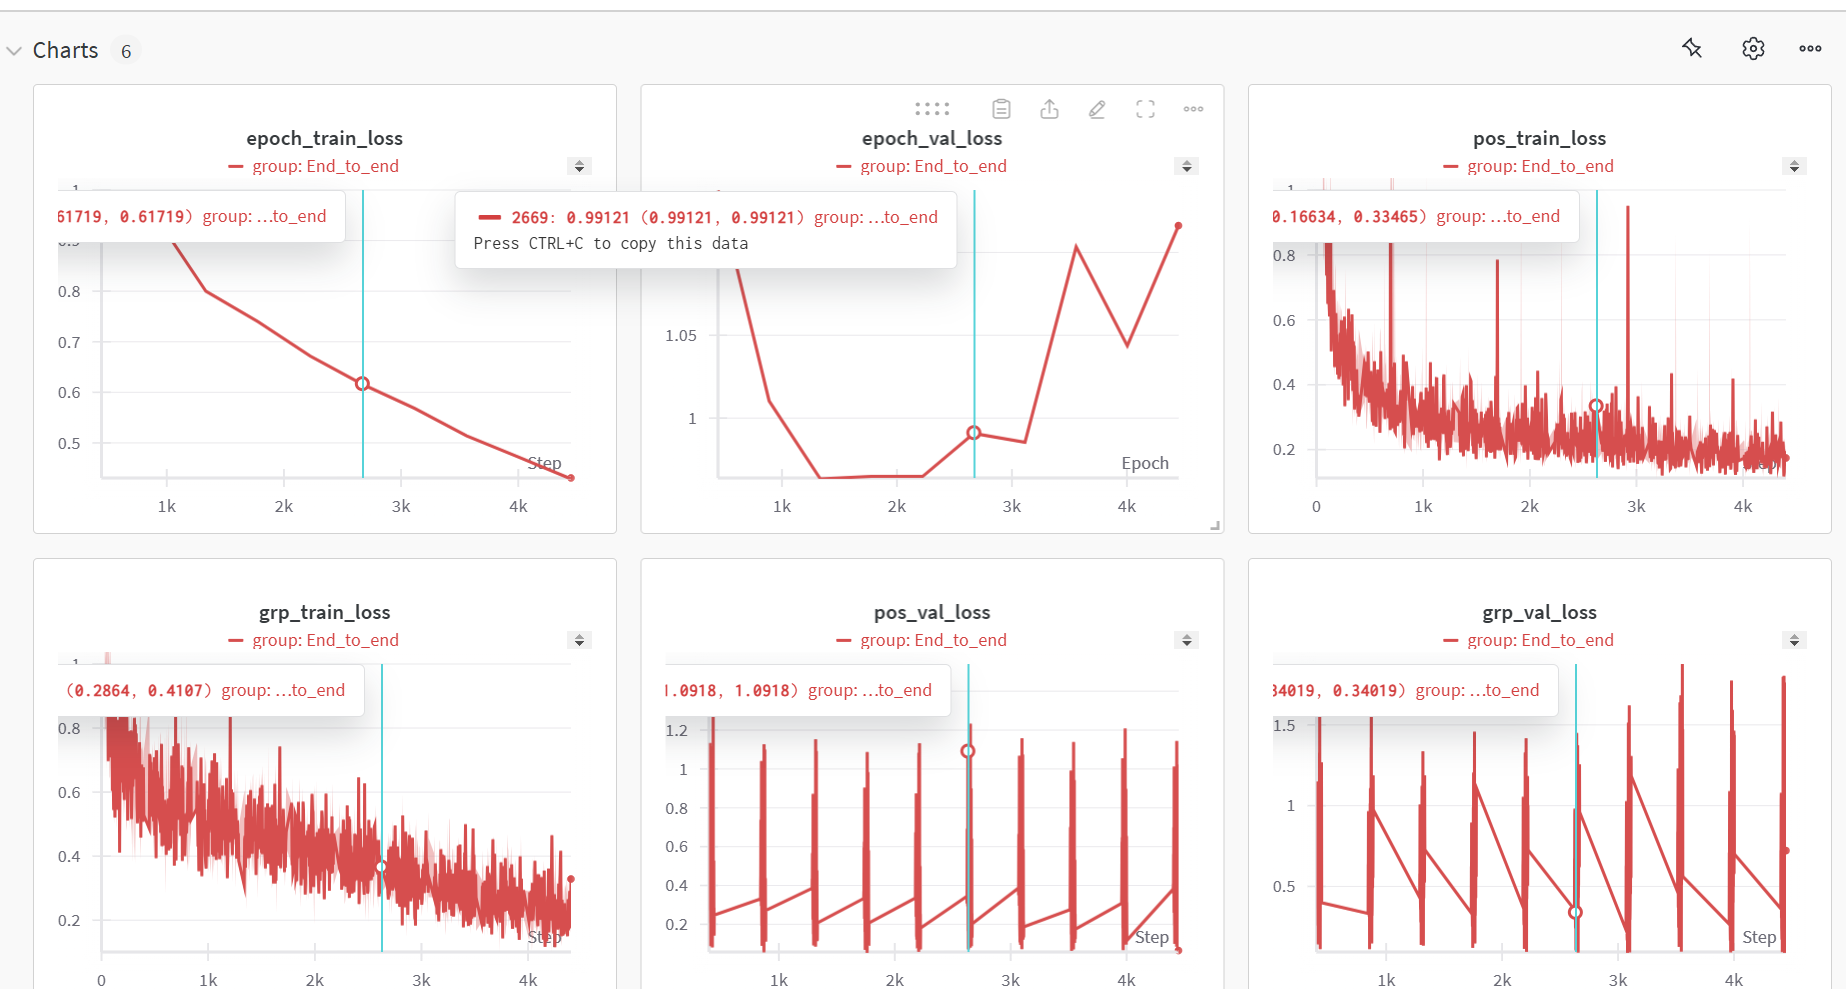

In [20]:
PREDS_PATH = '~/Modules/COMP0188_DeepLearning/COURSEWORK_2/results/baseline_preds/'

In [21]:
def load_prediction_files(epoch, pred_path):
    file_patterns = {
        'train_pos': f'epoch_{epoch}_train_preds_pos.csv',
        'train_grp': f'epoch_{epoch}_train_preds_grp.csv',
        'val_pos': f'epoch_{epoch}_val_preds_pos.csv',
        'val_grp': f'epoch_{epoch}_val_preds_grp.csv'
    }
    
    dfs = {}
    for key, filename in file_patterns.items():
        file_path = pred_path + filename
        dfs[key] = pd.read_csv(file_path)
        print(f"Loaded {key}: {dfs[key].shape} rows")
        
    return dfs

epoch_6_preds = load_prediction_files(6, PREDS_PATH)

# Access individual dataframes
train_pos_df = epoch_6_preds['train_pos']
train_grp_df = epoch_6_preds['train_grp']
val_pos_df = epoch_6_preds['val_pos']
val_grp_df = epoch_6_preds['val_grp']

Loaded train_pos: (1273, 3) rows
Loaded train_grp: (1273, 3) rows
Loaded val_pos: (580, 3) rows
Loaded val_grp: (580, 3) rows



Position Data Statistics:
-----------------------

train_pos Statistics:
                 x            y            z
count  1273.000000  1273.000000  1273.000000
mean      0.000042     0.002186    -0.001739
std       1.000289     1.012786     1.019113
min      -2.261719    -2.669922    -2.310547
25%      -0.218384    -0.163940    -0.672363
50%      -0.031494     0.156982     0.018005
75%       0.176025     0.395264     0.353027
max       2.275391     2.994141     2.445312

train_pos Correlations:
          x         y         z
x  1.000000 -0.050514  0.050032
y -0.050514  1.000000  0.169283
z  0.050032  0.169283  1.000000

val_pos Statistics:
                x           y           z
count  580.000000  580.000000  580.000000
mean    -0.301332   -0.086815   -0.207042
std      1.118016    0.970624    1.069426
min     -3.083984   -2.259766   -3.402344
25%     -0.730225   -0.607422   -0.813721
50%     -0.194885   -0.031364   -0.194397
75%      0.548584    0.371704    0.260681
max      1.

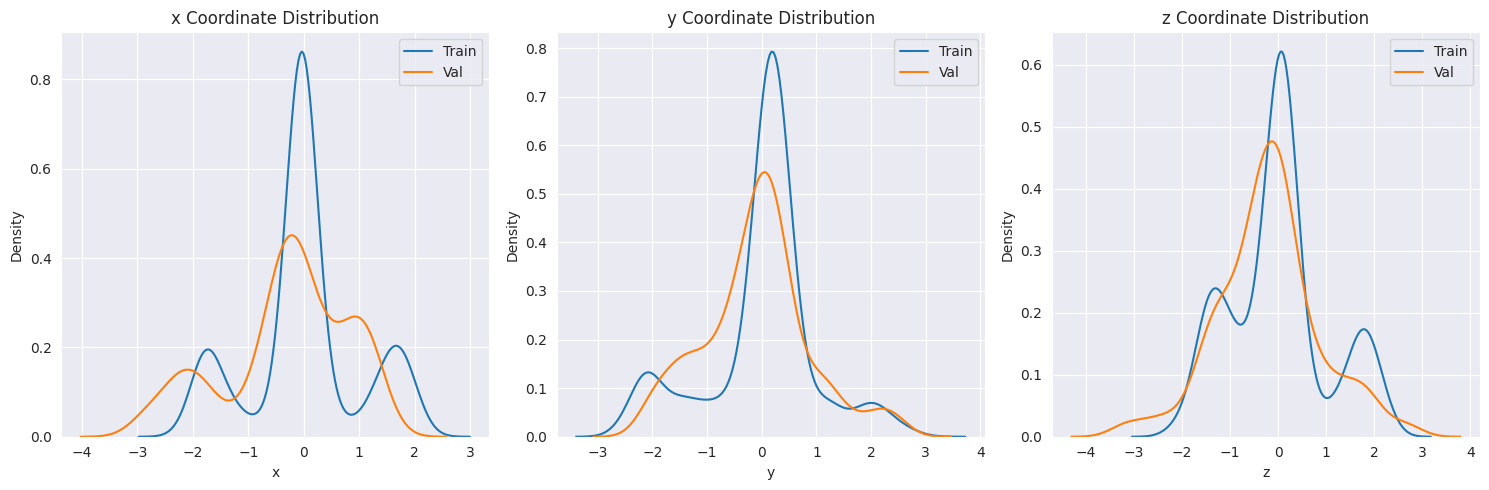

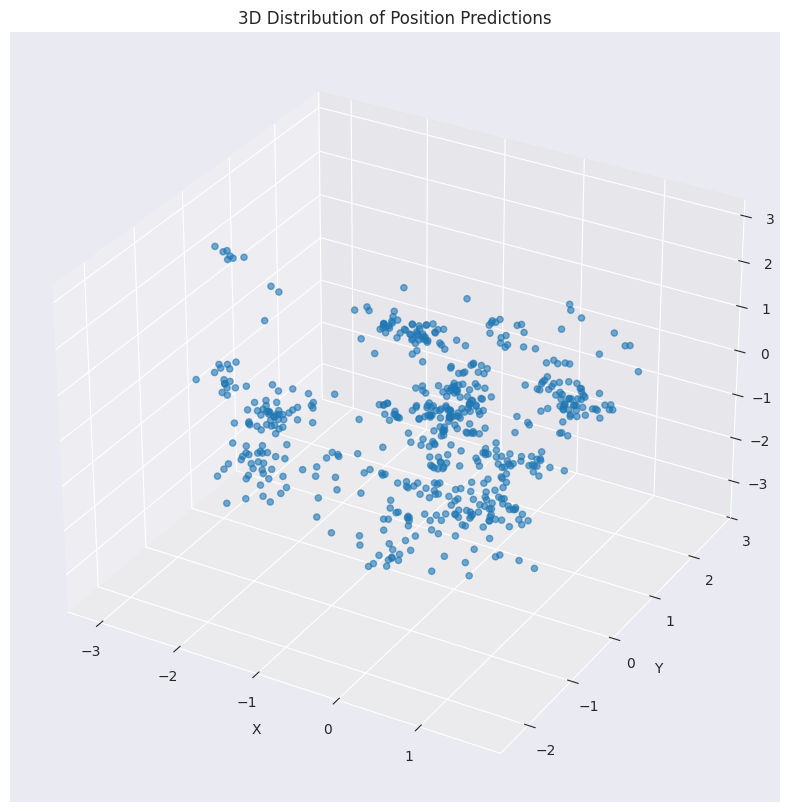

In [22]:
# Add column names that make sense based on the task
position_cols = ['x', 'y', 'z']  # 3 coordinates for robot arm movement
for key in ['train_pos', 'val_pos']:
    epoch_6_preds[key].columns = position_cols

# Let's look at the distribution of values and correlations
print("\nPosition Data Statistics:")
print("-----------------------")
for key in ['train_pos', 'val_pos']:
    print(f"\n{key} Statistics:")
    print(epoch_6_preds[key].describe())
    
    # Let's also look at correlations between the coordinates
    print(f"\n{key} Correlations:")
    print(epoch_6_preds[key].corr())

# Visualize the distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))

# Plot distribution of values for each coordinate
for i, coord in enumerate(position_cols):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=epoch_6_preds['train_pos'][coord], label='Train')
    sns.kdeplot(data=epoch_6_preds['val_pos'][coord], label='Val')
    plt.title(f'{coord} Coordinate Distribution')
    plt.legend()

plt.tight_layout()
plt.show()

# Let's also look at the 3D distribution of points
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample a subset of points to make visualization clearer
sample_size = min(1000, len(epoch_6_preds['val_pos']))
sampled_data = epoch_6_preds['val_pos'].sample(n=sample_size)

ax.scatter(sampled_data['x'], sampled_data['y'], sampled_data['z'], alpha=0.6)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Distribution of Position Predictions')
plt.show()

In [23]:
# Convert logits to predicted class
def analyze_gripper_predictions(grp_df):
    # Convert to tensor for easier manipulation
    logits = torch.tensor(grp_df.values)
    
    # Get predicted class (0,1,2) by taking argmax of logits
    predictions = torch.argmax(logits, dim=1)
    
    # Basic statistics
    print("\nGripper Prediction Distribution:")
    values, counts = torch.unique(predictions, return_counts=True)
    for val, count in zip(values, counts):
        print(f"Action {int(val)} ({'Do Nothing' if val==0 else 'Open' if val==1 else 'Close'}): {count} ({count/len(predictions)*100:.2f}%)")

# Analyze both train and validation predictions
for name in ['train_grp', 'val_grp']:
    print(f"\nAnalyzing {name}:")
    analyze_gripper_predictions(epoch_6_preds[name])


Analyzing train_grp:

Gripper Prediction Distribution:
Action 0 (Do Nothing): 131 (10.29%)
Action 1 (Open): 918 (72.11%)
Action 2 (Close): 224 (17.60%)

Analyzing val_grp:

Gripper Prediction Distribution:
Action 0 (Do Nothing): 79 (13.62%)
Action 1 (Open): 459 (79.14%)
Action 2 (Close): 42 (7.24%)


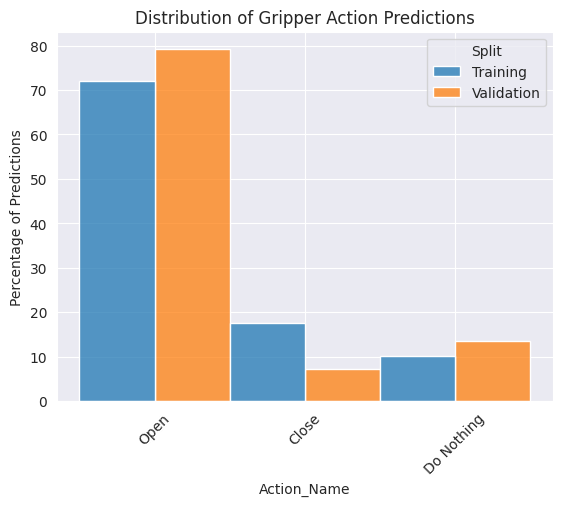

In [24]:
def get_predictions_df(grp_df, split='train'):
    # Convert logits to predicted classes
    logits = torch.tensor(grp_df.values)
    predictions = torch.argmax(logits, dim=1)
    
    # Convert predictions to pandas Series first
    action_names = pd.Series(predictions.numpy()).map({
        0: 'Do Nothing',
        1: 'Open', 
        2: 'Close'
    })
    
    # Create dataframe with predictions and labels
    return pd.DataFrame({
        'Action': predictions.numpy(),
        'Split': split,
        'Action_Name': action_names
    })

# Combine train and validation predictions
train_preds_df = get_predictions_df(epoch_6_preds['train_grp'], 'Training')
val_preds_df = get_predictions_df(epoch_6_preds['val_grp'], 'Validation')
all_preds = pd.concat([train_preds_df, val_preds_df])

# Create histogram with normalized percentages within each split
sns.histplot(
    data=all_preds, 
    x='Action_Name', 
    hue='Split',
    multiple="dodge",
    stat='percent',
    common_norm=False  # This ensures percentages sum to 100 within each split
)
plt.title('Distribution of Gripper Action Predictions')
plt.ylabel('Percentage of Predictions')
plt.xticks(rotation=45)
plt.show()

#### Question 1.b.ii.ii Performance evaluation (8 marks)
##### Task
- Draw conclusions regarding how well the model performs. To do this you may want to use additional metrics to the one(s) already reported. Critically, you should __contextualise__ the performance of the model. We are expecting discussion points a long the lines: _The model achieved a score of X according to metric Y. This suggests that the model is/is not performing well, because..._

**Performance Evaluation:**

** **

#### Question 1.b.ii.iii Model failure modes (9 marks)
##### Task
- Investigate the failure modes of the model. You should: 
  - Demonstrate the failure mode using **empirical evidence** e.g., _the model fails on X observations as demonstrated by..._
  - Assess the impact of these failure modes using **empirical evidence** i.e., how significant is this problem. You should consider both metrics and dataset coverage
  - Conclude __why__ the model might be failing on these observations **empirical evidence** e.g., _X part of the model performs poorly, as demonstrated by..._

__IMPORTANT__:
- Marks will be penalised if the failure modes you identify are not systematic i.e., you select a single observation that the model fails on. If you cannot identify any general failure modes of the model, you will be awarded full marks if you provide empirical evidence justifying why there are no systematic failure modes which sufficienty accounts for the diversity of observations in the dataset.


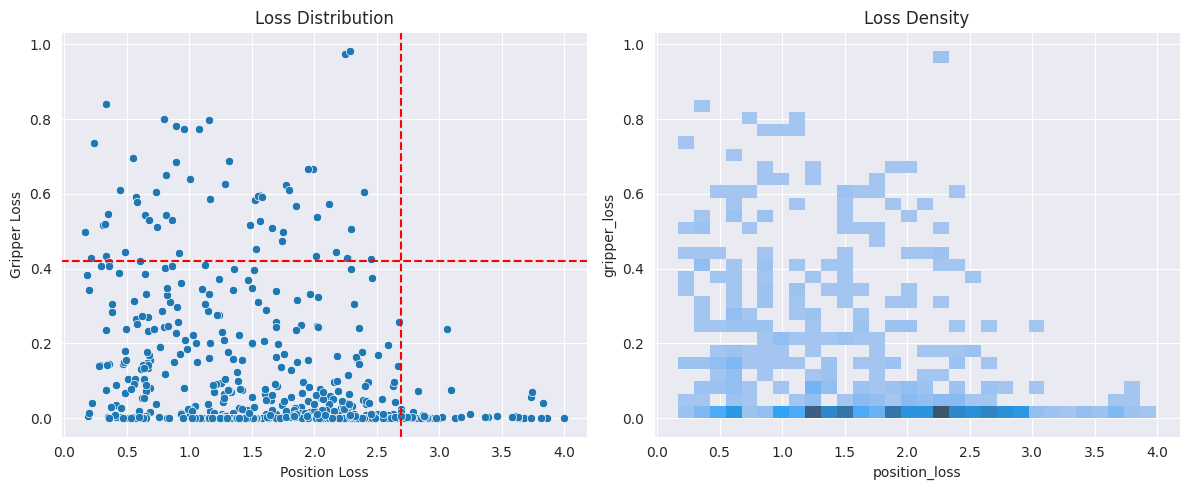


Failure Mode Analysis:
Total samples: 580
High position loss samples: 58
High gripper loss samples: 58
Samples with both high losses: 0


In [25]:

def calculate_losses_per_sample():
    # Calculate position losses (MSE for each sample)
    pos_df = epoch_6_preds['val_pos']
    positions = torch.tensor(pos_df.values)
    pos_losses = torch.norm(positions, dim=1)  # L2 norm of each position prediction
    
    # Calculate gripper losses (CrossEntropy for each sample)
    grp_df = epoch_6_preds['val_grp']
    logits = torch.tensor(grp_df.values)
    probs = F.softmax(logits, dim=1)
    max_probs = torch.max(probs, dim=1).values
    grp_losses = -torch.log(max_probs)  # Higher loss = lower confidence
    
    # Combine into DataFrame
    loss_df = pd.DataFrame({
        'position_loss': pos_losses.numpy(),
        'gripper_loss': grp_losses.numpy()
    })
    
    # Identify high loss samples (e.g., top 10%)
    pos_threshold = np.percentile(loss_df['position_loss'], 90)
    grp_threshold = np.percentile(loss_df['gripper_loss'], 90)
    
    loss_df['high_pos_loss'] = loss_df['position_loss'] > pos_threshold
    loss_df['high_grp_loss'] = loss_df['gripper_loss'] > grp_threshold
    
    return loss_df

# Calculate and analyze losses
loss_df = calculate_losses_per_sample()

# Plot the distribution of losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=loss_df, x='position_loss', y='gripper_loss')
plt.axvline(x=np.percentile(loss_df['position_loss'], 90), color='r', linestyle='--')
plt.axhline(y=np.percentile(loss_df['gripper_loss'], 90), color='r', linestyle='--')
plt.title('Loss Distribution')
plt.xlabel('Position Loss')
plt.ylabel('Gripper Loss')

plt.subplot(1, 2, 2)
sns.histplot(data=loss_df, x='position_loss', y='gripper_loss', bins=30)
plt.title('Loss Density')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nFailure Mode Analysis:")
print(f"Total samples: {len(loss_df)}")
print(f"High position loss samples: {loss_df['high_pos_loss'].sum()}")
print(f"High gripper loss samples: {loss_df['high_grp_loss'].sum()}")
print(f"Samples with both high losses: {(loss_df['high_pos_loss'] & loss_df['high_grp_loss']).sum()}")

### Question 1.c Model tuning
Now you have evaluated the proposed model, you are required to iterate and train a higher performing one. You are expected to run experiments that help you understand where the model is underperforming, guiding your development.

#### Question 1.c.i Model tuning (5 marks)
##### Task
- Using the code blocks below, implement a model which improves over the previous. Improve the performance as best you can and report the results using the metric/metrics you used in question 1.b.ii Model evaluation. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [14]:
# # First let's define improved CNN architecture with residual connections
# class ImprovedCNN(nn.Module):
#     def __init__(self, input_channels=1):
#         super().__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2)
#         )
        
#         # Residual connection
#         self.shortcut = nn.Sequential(
#             nn.Conv2d(input_channels, 64, kernel_size=1),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(8)  # Match spatial dimensions
#         )
        
#     def forward(self, x):
#         identity = self.shortcut(x)
#         out = self.conv1(x)
#         out = self.conv2(out)
#         out = self.conv3(out) 
#         return out + identity

# # Feature fusion module
# class FeatureFusionModule(nn.Module):
#     def __init__(self, in_channels):
#         super().__init__()
#         self.attention = nn.Sequential(
#             nn.Linear(in_channels, in_channels // 2),
#             nn.ReLU(),
#             nn.Linear(in_channels // 2, in_channels),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x1, x2):
#         # Compute attention weights
#         combined = x1 + x2
#         weights = self.attention(combined)
#         # Apply weighted fusion
#         fused = weights * x1 + (1 - weights) * x2
#         return fused

# # Improved model
# class ImprovedRoboticModel(BaseModel):
#     def __init__(self):
#         super().__init__()
        
#         # Separate CNNs for each camera view
#         self.front_cnn = ImprovedCNN(input_channels=1)
#         self.mount_cnn = ImprovedCNN(input_channels=1)
        
#         # Calculate CNN output dimensions
#         self.cnn_output_dim = 64 * 28 * 28  # Based on 224x224 input
        
#         # Feature fusion for visual features
#         self.visual_fusion = FeatureFusionModule(self.cnn_output_dim)
        
#         # Enhanced MLP for numerical data
#         self.numerical_encoder = nn.Sequential(
#             nn.Linear(15, 256),  # 15 numerical features
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )
        
#         # Final feature combination and prediction
#         self.combined_processor = nn.Sequential(
#             nn.Linear(self.cnn_output_dim + 128, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.3)
#         )
        
#         # Separate heads for position and gripper
#         self.position_head = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 3)  # 3D position
#         )
        
#         self.gripper_head = nn.Sequential(
#             nn.Linear(256, 64),
#             nn.ReLU(),
#             nn.Linear(64, 3)  # 3 gripper states
#         )

#     def forward(self, images, obs):
#         # Split and process images
#         front_img = images[:, 0:1, :, :]  # First channel
#         mount_img = images[:, 1:2, :, :]  # Second channel
        
#         # Process each image stream
#         front_features = self.front_cnn(front_img)
#         mount_features = self.mount_cnn(mount_img)
        
#         # Flatten CNN outputs
#         front_features = front_features.view(-1, self.cnn_output_dim)
#         mount_features = mount_features.view(-1, self.cnn_output_dim)
        
#         # Fuse visual features
#         visual_features = self.visual_fusion(front_features, mount_features)
        
#         # Process numerical data
#         numerical_features = self.numerical_encoder(obs)
        
#         # Combine all features
#         combined = torch.cat([visual_features, numerical_features], dim=1)
#         features = self.combined_processor(combined)
        
#         # Generate predictions
#         pos = self.position_head(features)
#         grp = self.gripper_head(features)
        
#         return {
#             "pos": pos,
#             "grp": grp
#         }
    
#     def reset(self, **kwargs):
#         torch.manual_seed(1)  # For reproducibility
        
        

In [ ]:
# # Initialize model and training components
# torch.manual_seed(1)
# model = ImprovedRoboticModel()

# # Training parameters
# exp_kwargs = {
#     "batch_size": 32,
#     "learning_rate": 0.001,
#     "half_precision": True,
#     "target_offset": 0
# }

# if project_options.debug:
#     exp_kwargs["batch_size"] = 4

# # Initialize optimizer with weight decay for regularization
# optimizer = torch.optim.AdamW(
#     model.parameters(),
#     lr=exp_kwargs["learning_rate"],
#     weight_decay=0.01
# )

# # Learning rate scheduler for better convergence
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=2,
#     verbose=True
# )

# # Loss functions
# pos_criterion = nn.MSELoss(reduction="mean")
# grp_criterion = nn.CrossEntropyLoss(reduction="mean")

# # Create dataloaders
# train_dataset = NpDictDataset(
#     array_dict=train_nps,
#     transform_lkp=global_transforms,
#     dep_vars=["actions"],
#     indep_vars=[
#         "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
#         "ee_cartesian_vel_ob", "joint_pos_ob"
#     ],
#     target_offset=exp_kwargs["target_offset"]
# )

# val_dataset = NpDictDataset(
#     array_dict=val_nps,
#     transform_lkp=global_transforms,
#     dep_vars=["actions"],
#     indep_vars=[
#         "front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob",
#         "ee_cartesian_vel_ob", "joint_pos_ob"
#     ],
#     target_offset=exp_kwargs["target_offset"]
# )

# train_dataloader = DataLoader(
#     train_dataset,
#     batch_size=exp_kwargs["batch_size"],
#     shuffle=True,
#     collate_fn=collate_func
# )

# val_dataloader = DataLoader(
#     val_dataset,
#     batch_size=exp_kwargs["batch_size"],
#     shuffle=False,
#     collate_fn=collate_func
# )

# # Training loop with metric tracking
# train_criterion = TrackerBalancedLoss(
#     loss_lkp={
#         "pos": copy.deepcopy(pos_criterion),
#         "grp": copy.deepcopy(grp_criterion)
#     },
#     name="train",
#     mo=WandBMetricOrchestrator()
# )

# val_criterion = TrackerBalancedLoss(
#     loss_lkp={
#         "pos": copy.deepcopy(pos_criterion),
#         "grp": copy.deepcopy(grp_criterion)
#     },
#     name="val", 
#     mo=WandBMetricOrchestrator()
# )

# # Initialize trainer
# trainer = TorchTrainingLoop(
#     model=model,
#     gpu=True,
#     optimizer=optimizer,
#     criterion=train_criterion,
#     val_criterion=val_criterion,
#     epochs=20,
#     logger=logger,
#     mo=WandBMetricOrchestrator(),
#     half_precision=exp_kwargs["half_precision"],
#     preds_save_type=None
# )

# # Set up WandB config
# wandb_name = "Tuned_Joint_CNN"
# wandb_grp = "Tuned_Model_1C"

# if project_options.debug:
#     wandb_name = f"{wandb_name}_DEBUG"

# # Train model
# orig = datetime.datetime.now()
# trainer.training_loop(
#     train_loader=train_dataloader,
#     val_loader=val_dataloader,
#     wandb_proj=WANDB_PROJECT,
#     wandb_grp=wandb_grp,
#     wandb_config=exp_kwargs,
#     wandb_name=wandb_name,
#     reset_kwargs={}
# )
# post_train = datetime.datetime.now()

# print(f"Training time: {post_train - orig}")

/cs/student/msc/aibh/2024/gcosta/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NameError: name 'collate_func' is not defined

#### Question 1.c.ii Discussion (marks broken down in subsections below)

##### Task
In the markdown blocks below, discuss **three** experiments that you ran during the development of your model, defined in 1.c.i Model tuning which were the **most insightful** with respect to the design of your final model. Importantly, **most insightful** needn't necessarily be the final decisions that appear in the model defined in question 1.c.i Model tuning, rather they should be experiments that most shaped your model development process. For example: 
- You might decide to use a learning rate scheduler and decrease the learning rate at epoch 10 (call this experiment "EXP_LR");
- This experiment produces a jump in performance and unlocks a series of further fruitful experiments into learning rate scheduling;
- However, in the model reported in question 1.c.i Model tuning, you use a learning rate schedule with descreases at epochs 6 and 15 (since these produced a marginal performance over "EXP_LR")
- For this question __you should discuss EXP_LR__.
  
For each experiment, complete the "Description", "Result" and "Conclusion" sections where the following information should be provided:
* __Description__: What delta were you measuring i.e., change of architecture, change of learning rate etc?
* __Justification__: **Why** are you conducting the experiment?
  * What was the context of the model development process up to this point? What did you already know about how well the model performed/why it was performing/what were the challenging data points?
* __Conclusion__: What did you __learn__ from the experiment and provide __empirical evidence__ to support this claim. In drawing your conclusions, consider where there are multiple possible causes for the model failing, ensure you provide evidence for each of these and conclude whether or not they might be root cause (you may conclude that there are multiple causes).

**IMPORTANT** If your reported experiments are **not** well motivated and do not demonstrate that you have integrogated the model performance, you will be deducted marks. An example of poor motovation might be: *I chose to decrease the learning rate from X to Y as I did not know what impact this might have*. This justification could be improved by explaining what you __already know__ about how the learning rate might be affecting the model. What hypotheses might you draw about what the experiment will show?



#### Question 1.c.ii.i Experiment 1 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

#### Question 1.c.ii.ii Experiment 2 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

#### Question 1.c.ii.iii Experiment 3 discussion (10 marks)

##### Description


##### Justification


##### Conclusion

## Question 2 Self-supervised pretraining with VAEs

This question requires you to implement a self-supervised approach using a VAE architecture. The focus of question 2 is in developing a VAE model without using __any__ supervised information i.e., without using any action information. You will assess the convergence of the model and the suitability of the learnt latent space. You are required to select and appropriate architecture/loss function/target set of observations to perform self-supervised learning over.

__IMPORTANT__: Do not use any of the __action__ information. You will be awarded 0 marks if you do.

### Question 2.a Self-supervised VAE model (5 marks)

##### Task
- Implement the full model training process and model definiton in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [20]:
"""VAE Dataloaders"""

def create_vae_dataloaders(train_nps: dict, val_nps: dict, batch_size: int, global_transforms: dict, collate_fn_vae: callable):
    """
    Create training and validation dataloaders for the VAE
    
    Args:
        train_nps (dict): Training data dictionary
        val_nps (dict): Validation data dictionary
        batch_size (int): Batch size
        global_transforms (dict): Dictionary of transforms
        collate_fn_vai: Collate method
        
    Returns:
        tuple: (train_dataloader, val_dataloader)
    """
    # Create training dataset
    train_dataset = NpDictDataset(
        array_dict=train_nps,
        transform_lkp=global_transforms,
        dep_vars=[],  # No dependent variables for self-supervised learning
        indep_vars=[
            "front_cam_ob",
            "mount_cam_ob",
            "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob",
            "joint_pos_ob"
        ]
    )
    
    # Create validation dataset
    val_dataset = NpDictDataset(
        array_dict=val_nps,
        transform_lkp=global_transforms,
        dep_vars=[],  # No dependent variables for self-supervised learning
        indep_vars=[
            "front_cam_ob",
            "mount_cam_ob",
            "ee_cartesian_pos_ob",
            "ee_cartesian_vel_ob",
            "joint_pos_ob"
        ]
    )
    
    # Create dataloaders
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_vae,
        num_workers=4,
        pin_memory=True
    )
    
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn_vae,
        num_workers=4,
        pin_memory=True
    )
    
    return train_dataloader, val_dataloader

"""Note to self: Half precision is commonly used in industry, unless you are training a huge model where those extra bits are necessary."""

def collate_fn_vae(batch_list):
    """
    Custom collate function for VAE dataloader that properly combines all inputs
    """
    # Initialize lists for each modality
    images = []
    obs = []
    
    for sample in batch_list:
        # Combine front and mount camera images
        combined_img = torch.cat([
            sample.input["front_cam_ob"], 
            sample.input["mount_cam_ob"]
        ], dim=0).half()  # Convert to half precision
        
        # Combine numerical observations
        combined_obs = torch.cat([
            sample.input["ee_cartesian_pos_ob"],
            sample.input["ee_cartesian_vel_ob"], 
            sample.input["joint_pos_ob"]
        ], dim=0).half()  # Convert to half precision
        
        images.append(combined_img)
        obs.append(combined_obs)
    
    # Stack into batches
    images = torch.stack(images)  # Shape: [batch_size, 2, 224, 224]
    obs = torch.stack(obs)      # Shape: [batch_size, 15]
    
    return DatasetOutput(
        input={
            "images": images,
            "obs": obs
        },
        output={}
    )



Notes:

https://www.youtube.com/watch?v=VELQT1-hILo

https://www.youtube.com/watch?v=qJeaCHQ1k2w&t=524s

UCL x Deepmind Latent Variable Models lecture:

https://www.youtube.com/watch?v=7Pcvdo4EJeo

Checkerboard noise bug:

https://distill.pub/2016/deconv-checkerboard/
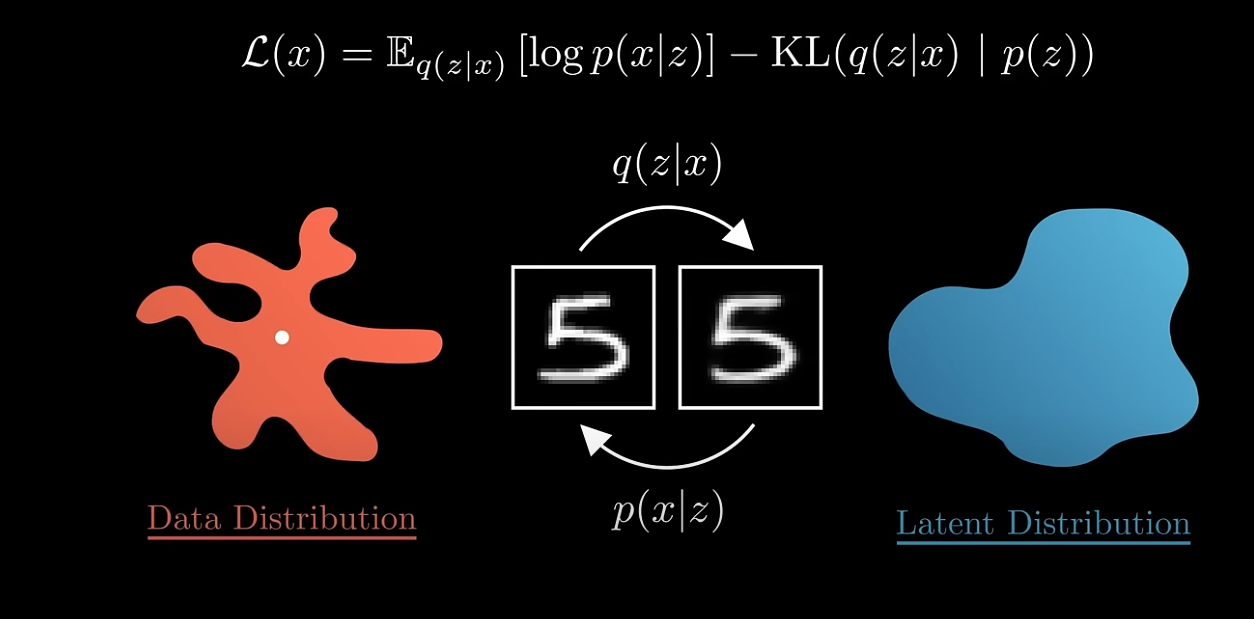


In [21]:
import torch.nn.functional as F
import wandb

from utils.vae_utils import VAELossPlotter

#NOTE: inspiration from https://www.youtube.com/watch?v=VELQT1-hILo
    
class VAE(nn.Module):
    def __init__(self, image_size=224, latent_dim=128):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        
#      ███
#      ██████
#      ████████
#      ██████
#      ███

        self.image_encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        # ███
        # ███
        # ███
        
        # Encoder for numerical observations
        self.numerical_encoder = nn.Sequential(
            nn.Linear(15, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Calculate flattened size of image features
        # self._img_feat_size = 256 * (image_size // 16) * (image_size // 16)
        self._img_feat_size = 256 * 14 * 14  # Based on final conv output size
        
        # Latent space projections
        self.fc_mu = nn.Linear(self._img_feat_size + 64, latent_dim)
        self.fc_logvar = nn.Linear(self._img_feat_size + 64, latent_dim)
        
        # Decoder layers
        self.decoder_linear = nn.Linear(latent_dim, self._img_feat_size + 64)
        # self.decoder_linear = nn.Linear(latent_dim, self._img_feat_size)
        
#           ███
#        ██████
#      ████████
#        ██████
#           ███        
        # # Image decoder
        # self.image_decoder = nn.Sequential(
        #     nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),    
        #     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),

        #     # nn.Sigmoid()
        # )
        
        self.image_decoder = nn.Sequential(
            # Start with feature maps at 14x14
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 2, kernel_size=3, padding=1),
            # OutputScaling(-2, 2)
        )        
        
        # self.image_decoder = nn.Sequential(
        #     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),
        #     # Remove sigmoid here - we want outputs in the same range as inputs
        # )        
        
        # Numerical decoder
        self.numerical_decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 15)
        )
        
        # Convert model to half precision
        self.half()

    def encode(self, x_img, x_num):
        # Ensure inputs are half precision  
        x_img = x_img.half()
        x_num = x_num.half()
        
        # Encode images
        img_features = self.image_encoder(x_img)
        img_features = img_features.view(img_features.size(0), -1)
        
        # Encode numerical data
        num_features = self.numerical_encoder(x_num)
        
        # Combine features
        combined = torch.cat([img_features, num_features], dim=1)
        
        # Project to latent space
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined).clamp(-20, 2)  # Prevents extreme values
        
        return mu, logvar
    
    def decode(self, z):
        # Ensure latent vector is half precision
        z = z.half()
        
        # Decode to combined feature space
        combined = self.decoder_linear(z)
        
        # Split features
        img_features = combined[:, :self._img_feat_size]
        num_features = combined[:, self._img_feat_size:]
        
        # Reshape image features
        # img_size = self.image_size // 16
        img_size = 14
        img_features = img_features.view(-1, 256, img_size, img_size)
        
        # Decode images and numerical data
        decoded_img = self.image_decoder(img_features)
        decoded_num = self.numerical_decoder(num_features)
        
        return decoded_img, decoded_num    
    
    def reparameterize(self, mu, logvar):
        if self.training:
            # Clamp logvar to prevent numerical instability
            logvar = torch.clamp(logvar, -20, 2)
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def forward(self, x_img, x_num):
        # Ensure inputs are half precision
        x_img = x_img.half()
        x_num = x_num.half()
        
        mu, logvar = self.encode(x_img, x_num)
        z = self.reparameterize(mu, logvar)
        decoded_img, decoded_num = self.decode(z)
        return decoded_img, decoded_num, mu, logvar


def vae_loss(recon_img, x_img, recon_num, x_num, mu, logvar, beta=1.0):
    """
    Numerically stable VAE loss that returns all components
    """
    # MSE loss without clamping since we removed sigmoid
    recon_loss_img = F.mse_loss(recon_img, x_img, reduction='mean')
    
    recon_loss_num = F.mse_loss(
        torch.clamp(recon_num, -10, 10),
        torch.clamp(x_num, -10, 10),
        reduction='mean'
    )

    # Numerically stable KL divergence
    kld = -0.5 * torch.mean(
        1 + torch.clamp(logvar, -20, 2) - mu.pow(2) - torch.exp(torch.clamp(logvar, -20, 2))
    )

    # Scale losses
    total_loss = recon_loss_img + 0.1 * recon_loss_num + beta * kld
    
    return total_loss, recon_loss_img, recon_loss_num, kld


# Modify the train_vae function to work with the new dataloader format
def train_vae(model, wandb, train_loader: DataLoader, val_loader: DataLoader, optimizer, device, num_epochs=10, beta=1.0):
    """
    Training loop for VAE with validation and half precision handling
    """
    model = model.to(device)
    loss_plotter = VAELossPlotter()
    
    for epoch in range(num_epochs):
        model.train()
        train_total = 0
        train_recon_img = 0
        train_recon_num = 0
        train_kld = 0
        
        for batch_idx, batch in enumerate(train_loader):
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            with torch.autocast('cuda'):
                optimizer.zero_grad()
                recon_img, recon_num, mu, logvar = model(x_img, x_num)
                total_loss, recon_loss_img, recon_loss_num, kld = vae_loss(
                    recon_img, x_img, recon_num, x_num, mu, logvar, beta
                )
            
            total_loss.backward()
            optimizer.step()
            
            # Accumulate losses
            train_total += total_loss.item()
            train_recon_img += recon_loss_img.item()
            train_recon_num += recon_loss_num.item()
            train_kld += kld.item()
        
        # Validation
        model.eval()
        val_total = 0
        val_recon_img = 0
        val_recon_num = 0
        val_kld = 0
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                x_img = batch.input["images"].to(device)
                x_num = batch.input["obs"].to(device)
                
                with torch.autocast('cuda'):
                    recon_img, recon_num, mu, logvar = model(x_img, x_num)
                    total_loss, recon_loss_img, recon_loss_num, kld = vae_loss(
                        recon_img, x_img, recon_num, x_num, mu, logvar, beta
                    )
                
                val_total += total_loss.item()
                val_recon_img += recon_loss_img.item()
                val_recon_num += recon_loss_num.item()
                val_kld += kld.item()
        
        # Calculate averages 
        train_total /= len(train_loader.dataset)
        train_recon_img /= len(train_loader.dataset)
        train_recon_num /= len(train_loader.dataset)
        train_kld /= len(train_loader.dataset)
        
        val_total /= len(val_loader.dataset)
        val_recon_img /= len(val_loader.dataset)
        val_recon_num /= len(val_loader.dataset)
        val_kld /= len(val_loader.dataset)
        
        
        wandb.log({
            "epoch": epoch,
            "train_total_loss": train_total,
            "train_recon_img_loss": train_recon_img,
            "train_recon_num_loss": train_recon_num,
            "train_kl_loss": train_kld,
            "val_total_loss": val_total,
            "val_recon_img_loss": val_recon_img,
            "val_recon_num_loss": val_recon_num,
            "val_kl_loss": val_kld
        })
        
        # Add to plotter
        loss_plotter.add_epoch_losses(
            epoch=epoch,
            train_total_loss=train_total,
            train_recon_img_loss=train_recon_img,
            train_recon_num_loss=train_recon_num,
            train_kl_loss=train_kld,
            val_total_loss=val_total,
            val_recon_img_loss=val_recon_img,
            val_recon_num_loss=val_recon_num,
            val_kl_loss=val_kld
        )
        
        print(f'Epoch {epoch}:')
        print(f'Train - Total: {train_total:.4f}, Img: {train_recon_img:.4f}, '
              f'Num: {train_recon_num:.4f}, KLD: {train_kld:.4f}')
        print(f'Val   - Total: {val_total:.4f}, Img: {val_recon_img:.4f}, '
              f'Num: {val_recon_num:.4f}, KLD: {val_kld:.4f}')
    
    # Plot final results
    loss_plotter.plot_losses()
    loss_plotter.plot_loss_ratios()
    
    return loss_plotter

In [22]:
# Create and analyze dataloaders
from utils.vae_utils import analyze_dataloader


testing_train_dataloader, testing_val_dataloader = create_vae_dataloaders(train_nps, val_nps, 32, global_transforms, collate_fn_vae)

print("Analyzing Training DataLoader:")
analyze_dataloader(testing_train_dataloader)

print("\nAnalyzing Validation DataLoader:")
analyze_dataloader(testing_val_dataloader)

Analyzing Training DataLoader:

DataLoader Analysis:
-------------------

Batch 1:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.604, 2.664]
Mean: -0.005
NaN count: 0
Zero count: 1828

Batch 2:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.652, 2.656]
Mean: 0.001
NaN count: 0
Zero count: 1902

Batch 3:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.604, 2.645]
Mean: 0.030
NaN count: 0
Zero count: 2188

Batch 4:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.648, 2.652]
Mean: 0.003
NaN count: 0
Zero count: 1832

Batch 5:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.637, 2.662]
Mean: 0.031
NaN count: 0
Zero count: 1912

DataLoader Analysis Complete
-------------------------

Analyzing Validation DataLoader:

DataLoader Analysis:
-------------------

Batch 1:

Images:
Shape: torch.Size([32, 2, 224, 224])
Type: torch.float16
Range: [-2.57

In [23]:
# Print the transforms we're using
print("Global Transforms:")
for k, v in global_transforms.items():
    print(f"{k}: {v}")

# Let's check a single sample before and after transformation
print("\nChecking single sample transformation:")
idx = 0  # Check first sample

print("\nBefore transformation:")
for key in ["front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"]:
    data = train_nps[key][idx]
    print(f"\n{key}:")
    print(f"Shape: {data.shape}")
    print(f"Type: {data.dtype}")
    print(f"Range: [{data.min()}, {data.max()}]")
    print(f"Mean: {data.mean()}")

# Apply transforms to single sample
print("\nAfter transformation:")
transformed_data = {}
for key in ["front_cam_ob", "mount_cam_ob", "ee_cartesian_pos_ob", "ee_cartesian_vel_ob", "joint_pos_ob"]:
    transformed_data[key] = global_transforms[key](train_nps[key][idx])
    print(f"\n{key}:")
    print(f"Shape: {transformed_data[key].shape}")
    print(f"Type: {transformed_data[key].dtype}")
    print(f"Range: [{transformed_data[key].min().item()}, {transformed_data[key].max().item()}]")
    print(f"Mean: {transformed_data[key].mean().item()}")

Global Transforms:
front_cam_ob: Compose(
    ToTensor()
    Lambda()
    Normalize(mean=[0.4484155476093292], std=[0.216434046626091])
)
mount_cam_ob: Compose(
    ToTensor()
    Lambda()
    Normalize(mean=[0.5031079649925232], std=[0.18617898225784302])
)
ee_cartesian_pos_ob: <function <lambda> at 0x7ff09cecdf30>
ee_cartesian_vel_ob: <function <lambda> at 0x7ff09d1cdbd0>
joint_pos_ob: <function <lambda> at 0x7ff09d1ce320>
actions: <function <lambda> at 0x7ff09d1ce560>

Checking single sample transformation:

Before transformation:

front_cam_ob:
Shape: (224, 224)
Type: float16
Range: [0.896484375, 233.0]
Mean: 115.8125

mount_cam_ob:
Shape: (224, 224)
Type: float16
Range: [21.15625, 226.875]
Mean: 137.375

ee_cartesian_pos_ob:
Shape: (7,)
Type: float16
Range: [-0.41064453125, 0.9892578125]
Mean: 0.138427734375

ee_cartesian_vel_ob:
Shape: (6,)
Type: float16
Range: [-0.00922393798828125, 0.043426513671875]
Mean: 0.0081939697265625

joint_pos_ob:
Shape: (2,)
Type: float16
Range: [1.04

In [24]:
from dataclasses import dataclass


"""Using a dataclass to store my hyperparams.
This is so much better than using a dictionary.
"""
@dataclass(frozen=True)
class VAEHyperParams:
    NUM_EPOCHS: int = 12
    BETA: float = 3.0
    BATCH_SIZE: int = 64
    IMAGE_SIZE: int = 224
    LATENT_DIM: int = 127
    LEARNING_RATE: float = 1e-3
    EPSILON: float = 1e-4

    
params = VAEHyperParams()


DEBUG:git.cmd:Popen(['git', 'cat-file', '--batch-check'], cwd=/cs/student/msc/aibh/2024/gcosta/Modules/COMP0188_DeepLearning, stdin=<valid stream>, shell=False, universal_newlines=False)


Epoch 0:
Train - Total: 284.2185, Img: 0.0122, Num: 0.7144, KLD: 94.7116
Val   - Total: 25.2880, Img: 0.0142, Num: 0.4522, KLD: 8.4095
Epoch 1:
Train - Total: 6.9098, Img: 0.0122, Num: 0.0874, KLD: 2.2963
Val   - Total: 1.7018, Img: 0.0166, Num: 0.0300, KLD: 0.5607
Epoch 2:
Train - Total: 1.0473, Img: 0.0158, Num: 0.0268, KLD: 0.3429
Val   - Total: 0.6526, Img: 0.0240, Num: 0.0235, KLD: 0.2087
Epoch 3:
Train - Total: 0.4967, Img: 0.0175, Num: 0.0179, KLD: 0.1591
Val   - Total: 0.5213, Img: 0.0151, Num: 0.0223, KLD: 0.1680
Epoch 4:
Train - Total: 0.3913, Img: 0.0159, Num: 0.0168, KLD: 0.1246
Val   - Total: 0.4570, Img: 0.0186, Num: 0.0217, KLD: 0.1454
Epoch 5:
Train - Total: 0.3694, Img: 0.0152, Num: 0.0167, KLD: 0.1175
Val   - Total: 0.4328, Img: 0.0166, Num: 0.0216, KLD: 0.1380
Epoch 6:
Train - Total: 0.3527, Img: 0.0140, Num: 0.0165, KLD: 0.1123
Val   - Total: 0.4306, Img: 0.0157, Num: 0.0215, KLD: 0.1376
Epoch 7:
Train - Total: 0.3471, Img: 0.0131, Num: 0.0165, KLD: 0.1108
Val   - T

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/cs/student/msc/aibh/2024/gcosta/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 3.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/cs/student/msc/aibh/2024/gcosta/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 2.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/cs/student/msc/aibh/2024/gcosta/.local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
D

Epoch 11:
Train - Total: 0.3227, Img: 0.0096, Num: 0.0162, KLD: 0.1038
Val   - Total: 0.3985, Img: 0.0114, Num: 0.0213, KLD: 0.1283


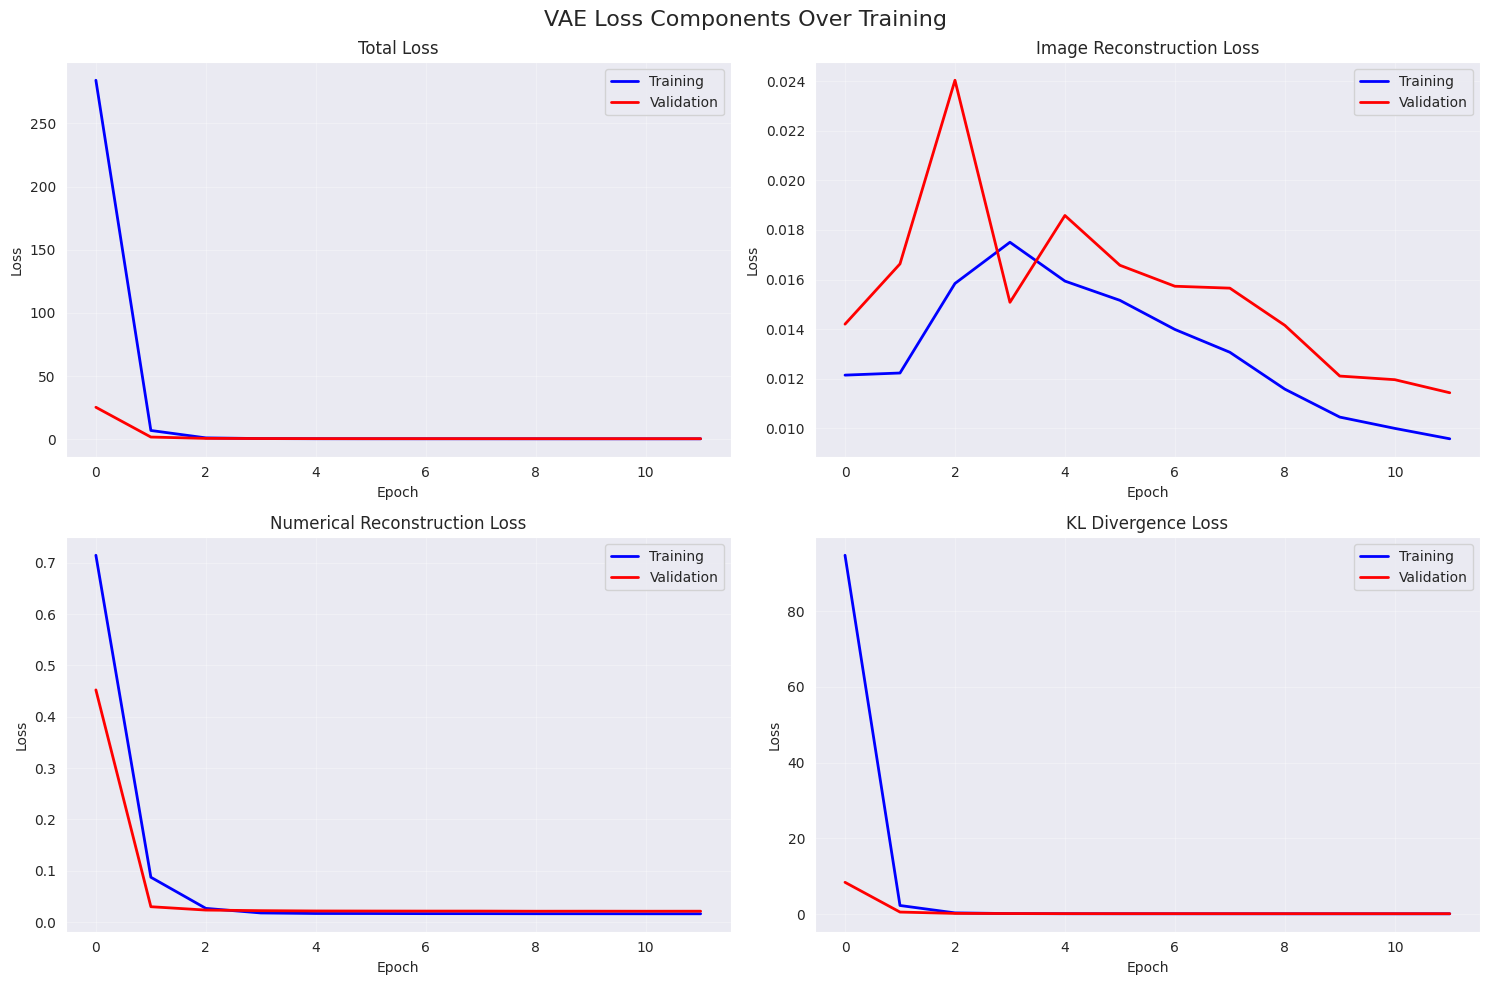

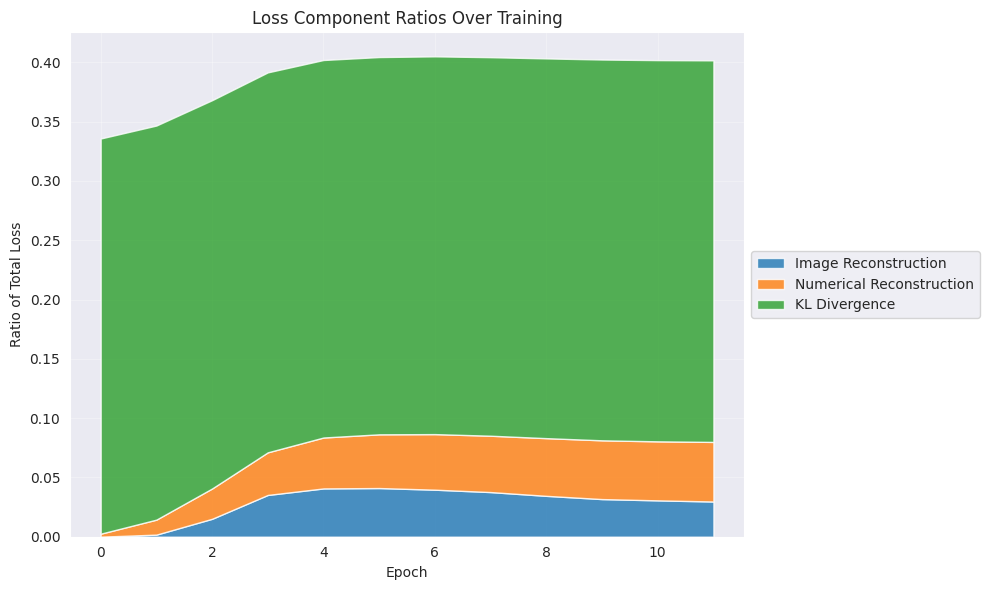

epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_kl_loss,█▁▁▁▁▁▁▁▁▁▁▁
train_recon_img_loss,▃▃▇█▇▆▅▄▃▂▁▁
train_recon_num_loss,█▂▁▁▁▁▁▁▁▁▁▁
train_total_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_kl_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_recon_img_loss,▃▄█▃▅▄▃▃▃▁▁▁
val_recon_num_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_total_loss,█▁▁▁▁▁▁▁▁▁▁▁
epoch,11
train_kl_loss,0.10383


In [25]:
# Set random seed for reproducibility
from dataclasses import asdict

torch.manual_seed(1)

train_dataloader, val_dataloader = create_vae_dataloaders(train_nps, val_nps, params.BATCH_SIZE, global_transforms, collate_fn_vae)

# Initialize model and training parameters
vae_model = VAE(image_size=params.IMAGE_SIZE, latent_dim=params.LATENT_DIM)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=params.LEARNING_RATE, eps=params.EPSILON)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config_dict = {k.lower(): v for k, v in asdict(params).items()}

# Initialize wandb
vae_wandb = wandb.init(
    project=WANDB_PROJECT,
    name=f"VAE_Self_Supervised_Half{'_DEBUG' if project_options.debug else ''}",
    config={
        **config_dict,
        "architecture": "VAE",
        "dataset": "robot_behavior",
        "encoder_layers": [32, 64, 128, 256],
        "decoder_layers": [256, 128, 64, 32],
        "numerical_encoder_dims": [128, 64],
        "optimizer": "Adam",
        "num_channels": 2,
        "numerical_features": 15,
        "precision": "float16",
        "device": str(device)
    }
)

# Train the model
train_vae(
    model=vae_model,
    wandb=vae_wandb,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    device=device,
    num_epochs=params.NUM_EPOCHS,
    beta=params.BETA,
)

vae_wandb.finish()





$$\text{Note to self: metrics}$$
| Component | Value | Explanation | Expected Range | Warning Signs |
|-----------|--------|-------------|----------------|---------------|
| **Loss Components** |
| Image Reconstruction Loss | 1.096037 | MSE loss between original and reconstructed images. Measures how well the VAE reconstructs visual data. | 0.5-2.0 | >3.0 suggests poor reconstruction; <0.1 may indicate memorization |
| Numerical Reconstruction Loss | 1.214381 | MSE loss between original and reconstructed numerical features (positions, velocities). | 0.5-2.0 | >3.0 suggests poor reconstruction; <0.1 may indicate memorization |
| KL Divergence Loss | 2.656353 | Measures how close the learned latent distribution is to a standard normal distribution. Regularizes the latent space. | 0.1-1.0 | >5.0 suggests over-regularization; <0.01 indicates posterior collapse |
| **Latent Space Statistics** |
| Mu Mean | -0.000200 | Average of the means of the learned latent distributions. Should be close to 0 for normal distribution. | -0.1 to 0.1 | Magnitude >0.5 suggests biased encoding |
| Mu Std | 0.254883 | Standard deviation of the means. Shows how spread out the encodings are. | 0.2-1.0 | <0.1 suggests collapsed latent space; >2.0 suggests unstable training |
| LogVar Mean | 29.546875 | Average of log variances. Controls the uncertainty in the latent space. | -2 to 2 | >5 or <-5 indicates numerical instability |
| LogVar Std | inf | Spread of log variances. Shows consistency of uncertainty estimates. | 0.1-2.0 | inf or nan indicates severe instability |

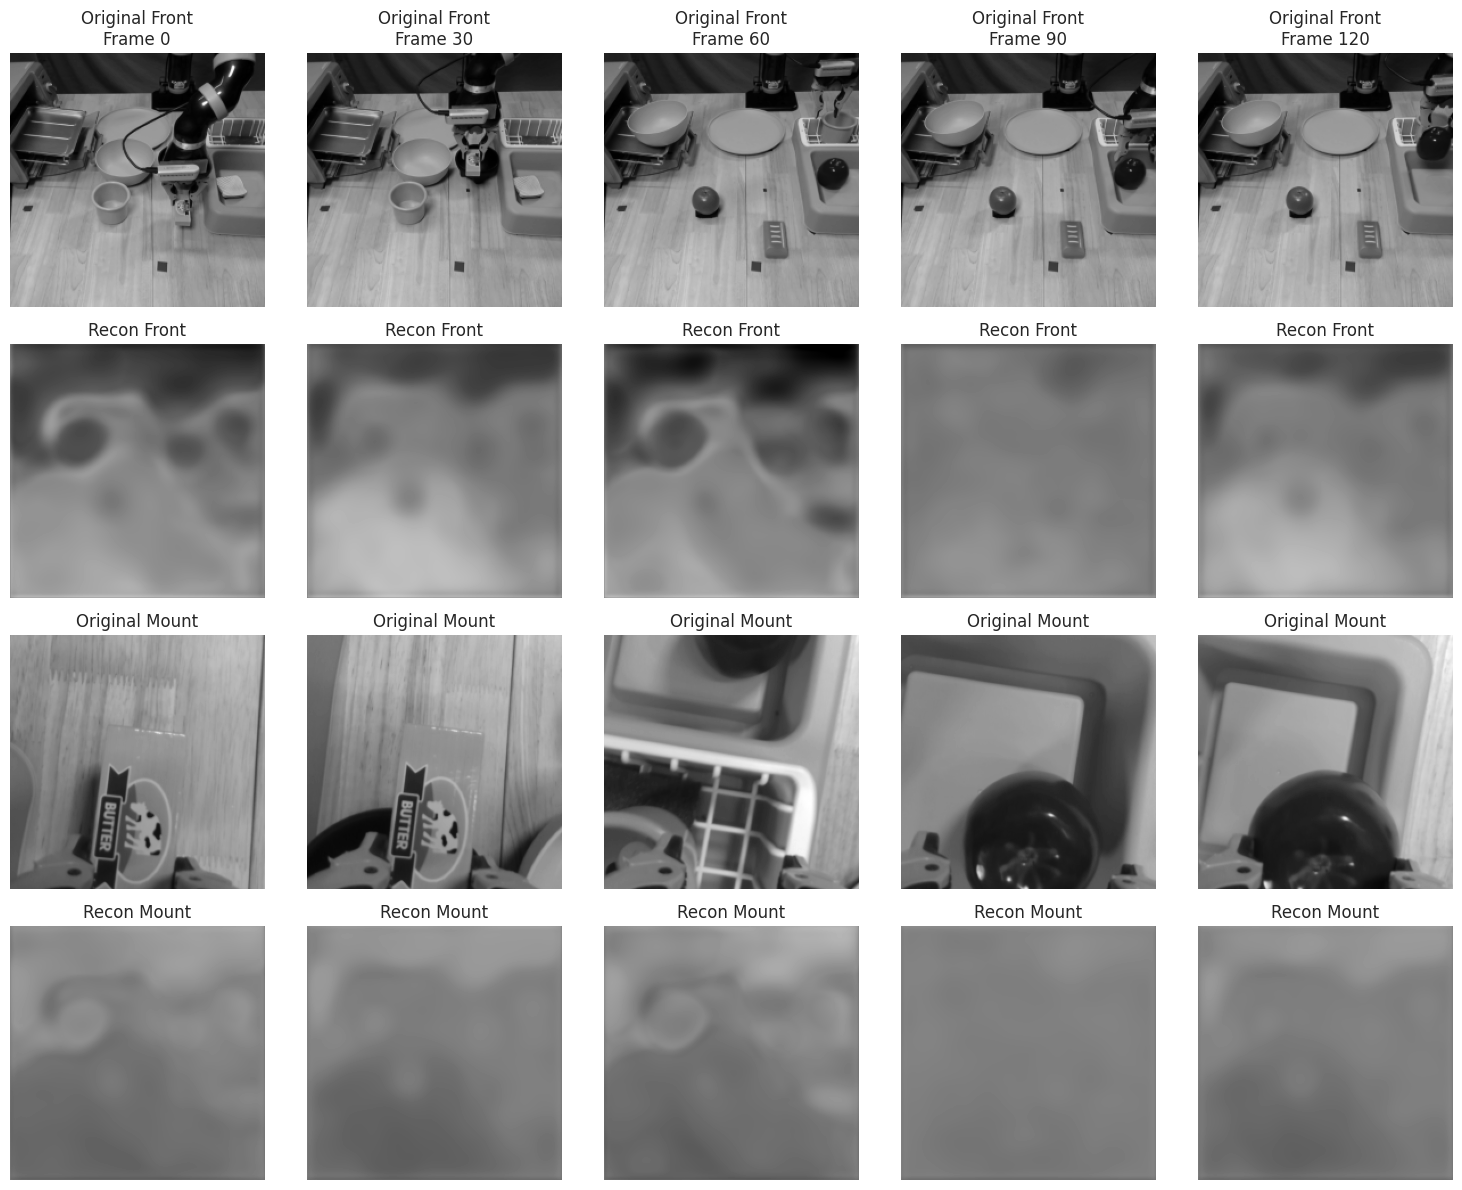

In [26]:
def visualize_reconstructions(model, val_loader, device, stride=30, num_samples=5):
    model.eval()
    with torch.no_grad():
        # Get samples
        all_images = []
        all_obs = []
        for batch in val_loader:
            all_images.append(batch.input["images"].cpu())
            all_obs.append(batch.input["obs"].cpu())
        
        all_images = torch.cat(all_images, dim=0)
        all_obs = torch.cat(all_obs, dim=0)
        
        indices = list(range(0, len(all_images), stride))[:num_samples]
        x_img = all_images[indices].to(device)
        x_num = all_obs[indices].to(device)
        
        # Get reconstructions
        recon_img, recon_num, _, _ = model(x_img, x_num)
        
        # First un-normalize back to [0,1] range
        front_mean, front_std = 0.4484155476093292, 0.216434046626091
        mount_mean, mount_std = 0.5031079649925232, 0.18617898225784302

        def unnormalize(x, mean, std):
            return (x * std) + mean
            
        # Then scale to [0,255] range
        x_front = unnormalize(x_img[:,0], front_mean, front_std) * 255
        x_mount = unnormalize(x_img[:,1], mount_mean, mount_std) * 255
        recon_front = unnormalize(recon_img[:,0], front_mean, front_std) * 255
        recon_mount = unnormalize(recon_img[:,1], mount_mean, mount_std) * 255
        
        # Plot with proper scaling
        fig, axes = plt.subplots(4, num_samples, figsize=(15, 12))
        
        for i in range(num_samples):
            # Original front camera
            axes[0,i].imshow(x_front[i].cpu().numpy(), cmap='gray', vmin=0, vmax=255)
            axes[0,i].set_title(f'Original Front\nFrame {indices[i]}')
            axes[0,i].axis('off')
            
            # Reconstructed front camera
            axes[1,i].imshow(recon_front[i].cpu().numpy(), cmap='gray', vmin=0, vmax=255)
            axes[1,i].set_title('Recon Front')
            axes[1,i].axis('off')
            
            # Original mount camera
            axes[2,i].imshow(x_mount[i].cpu().numpy(), cmap='gray', vmin=0, vmax=255)
            axes[2,i].set_title('Original Mount')
            axes[2,i].axis('off')
            
            # Reconstructed mount camera
            axes[3,i].imshow(recon_mount[i].cpu().numpy(), cmap='gray', vmin=0, vmax=255)
            axes[3,i].set_title('Recon Mount')
            axes[3,i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
visualize_reconstructions(vae_model, val_dataloader, device, num_samples=5)


Reconstruction Analysis:
Reconstructed image range: [-4.097656, 1.868164]
Reconstructed image mean: -0.002546
Reconstructed image std: 0.565918

Input Analysis:
Input image range: [-2.658203, 2.656250]
Input image mean: -0.070251
Input image std: 1.067383

Latent Analysis:
Mu range: [-11.453125, 10.640625]
LogVar range: [-20.000000, 2.000000]


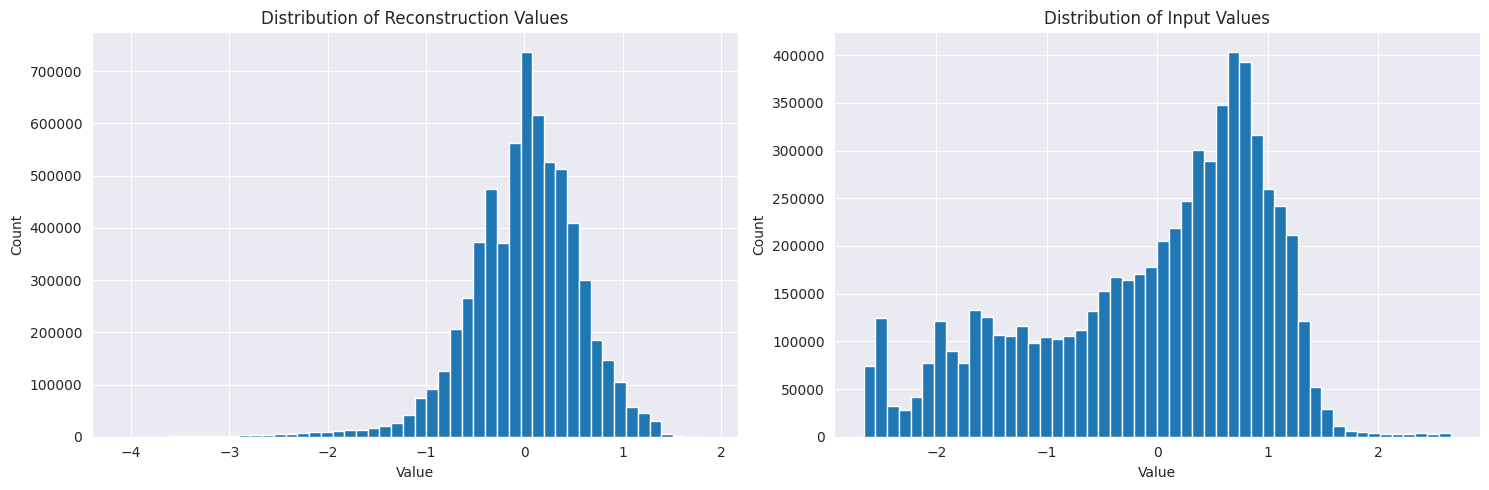

In [27]:
def analyze_reconstruction_values(model, val_loader, device):
    """Analyze the raw values of reconstructions before denormalization"""
    model.eval()
    with torch.no_grad():
        batch = next(iter(val_loader))
        x_img = batch.input["images"].to(device)
        x_num = batch.input["obs"].to(device)
        
        recon_img, recon_num, mu, logvar = model(x_img, x_num)
        
        print("\nReconstruction Analysis:")
        print(f"Reconstructed image range: [{recon_img.min().item():.6f}, {recon_img.max().item():.6f}]")
        print(f"Reconstructed image mean: {recon_img.mean().item():.6f}")
        print(f"Reconstructed image std: {recon_img.std().item():.6f}")
        
        print("\nInput Analysis:")
        print(f"Input image range: [{x_img.min().item():.6f}, {x_img.max().item():.6f}]")
        print(f"Input image mean: {x_img.mean().item():.6f}")
        print(f"Input image std: {x_img.std().item():.6f}")
        
        # Look at intermediate activations
        print("\nLatent Analysis:")
        print(f"Mu range: [{mu.min().item():.6f}, {mu.max().item():.6f}]")
        print(f"LogVar range: [{logvar.min().item():.6f}, {logvar.max().item():.6f}]")
        
        return recon_img, x_img

# Get some reconstructions before denormalization
recon_img, x_img = analyze_reconstruction_values(vae_model, val_dataloader, device)

# Let's also look at a histogram of values
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.hist(recon_img.cpu().numpy().flatten(), bins=50)
plt.title('Distribution of Reconstruction Values')
plt.xlabel('Value')
plt.ylabel('Count')

plt.subplot(122)
plt.hist(x_img.cpu().numpy().flatten(), bins=50)
plt.title('Distribution of Input Values')
plt.xlabel('Value')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Question 2.b Model convergence (12 marks)

##### Task
- Provide empirical evidence (in the form of appropriate training/validation metrics) supporting **why** the model is appropriately trained;
- Interpret why the metrics demonstrate that the model has converged. If your model has **not** converged, interpret why the metrics suggest so.

### Question 2.c Latent space analysis (6 marks)

##### Task
- Using reasonable analysis, conclude whether the representation learnt by the self-supervised method will be beneficial for the downstream supervised task. **Empirical evidence** should be provided **however**, references to the performance of the self-superised method with a supervised head on the downstream task will be awarded __0 marks__. 

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff1216e2b30>


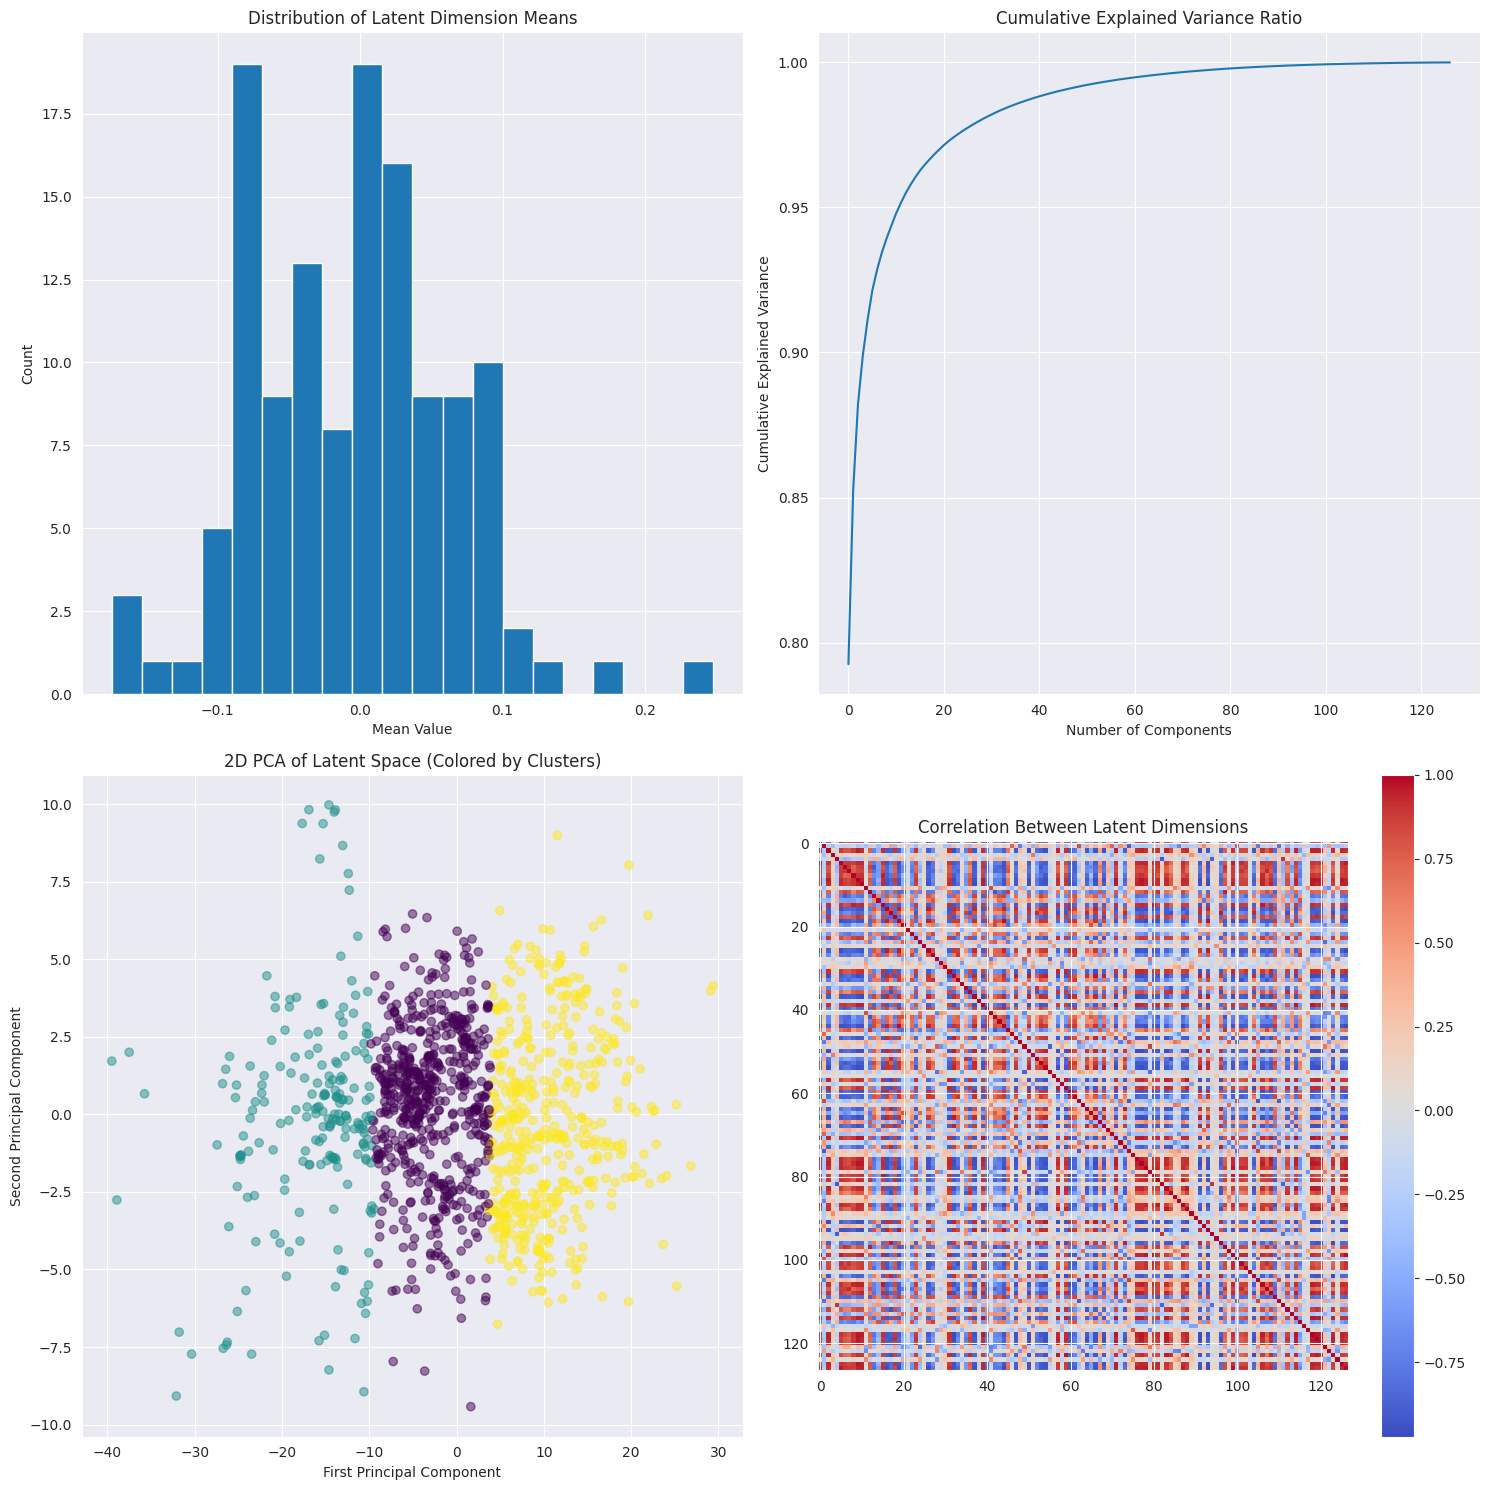

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7ff12cf9d630>


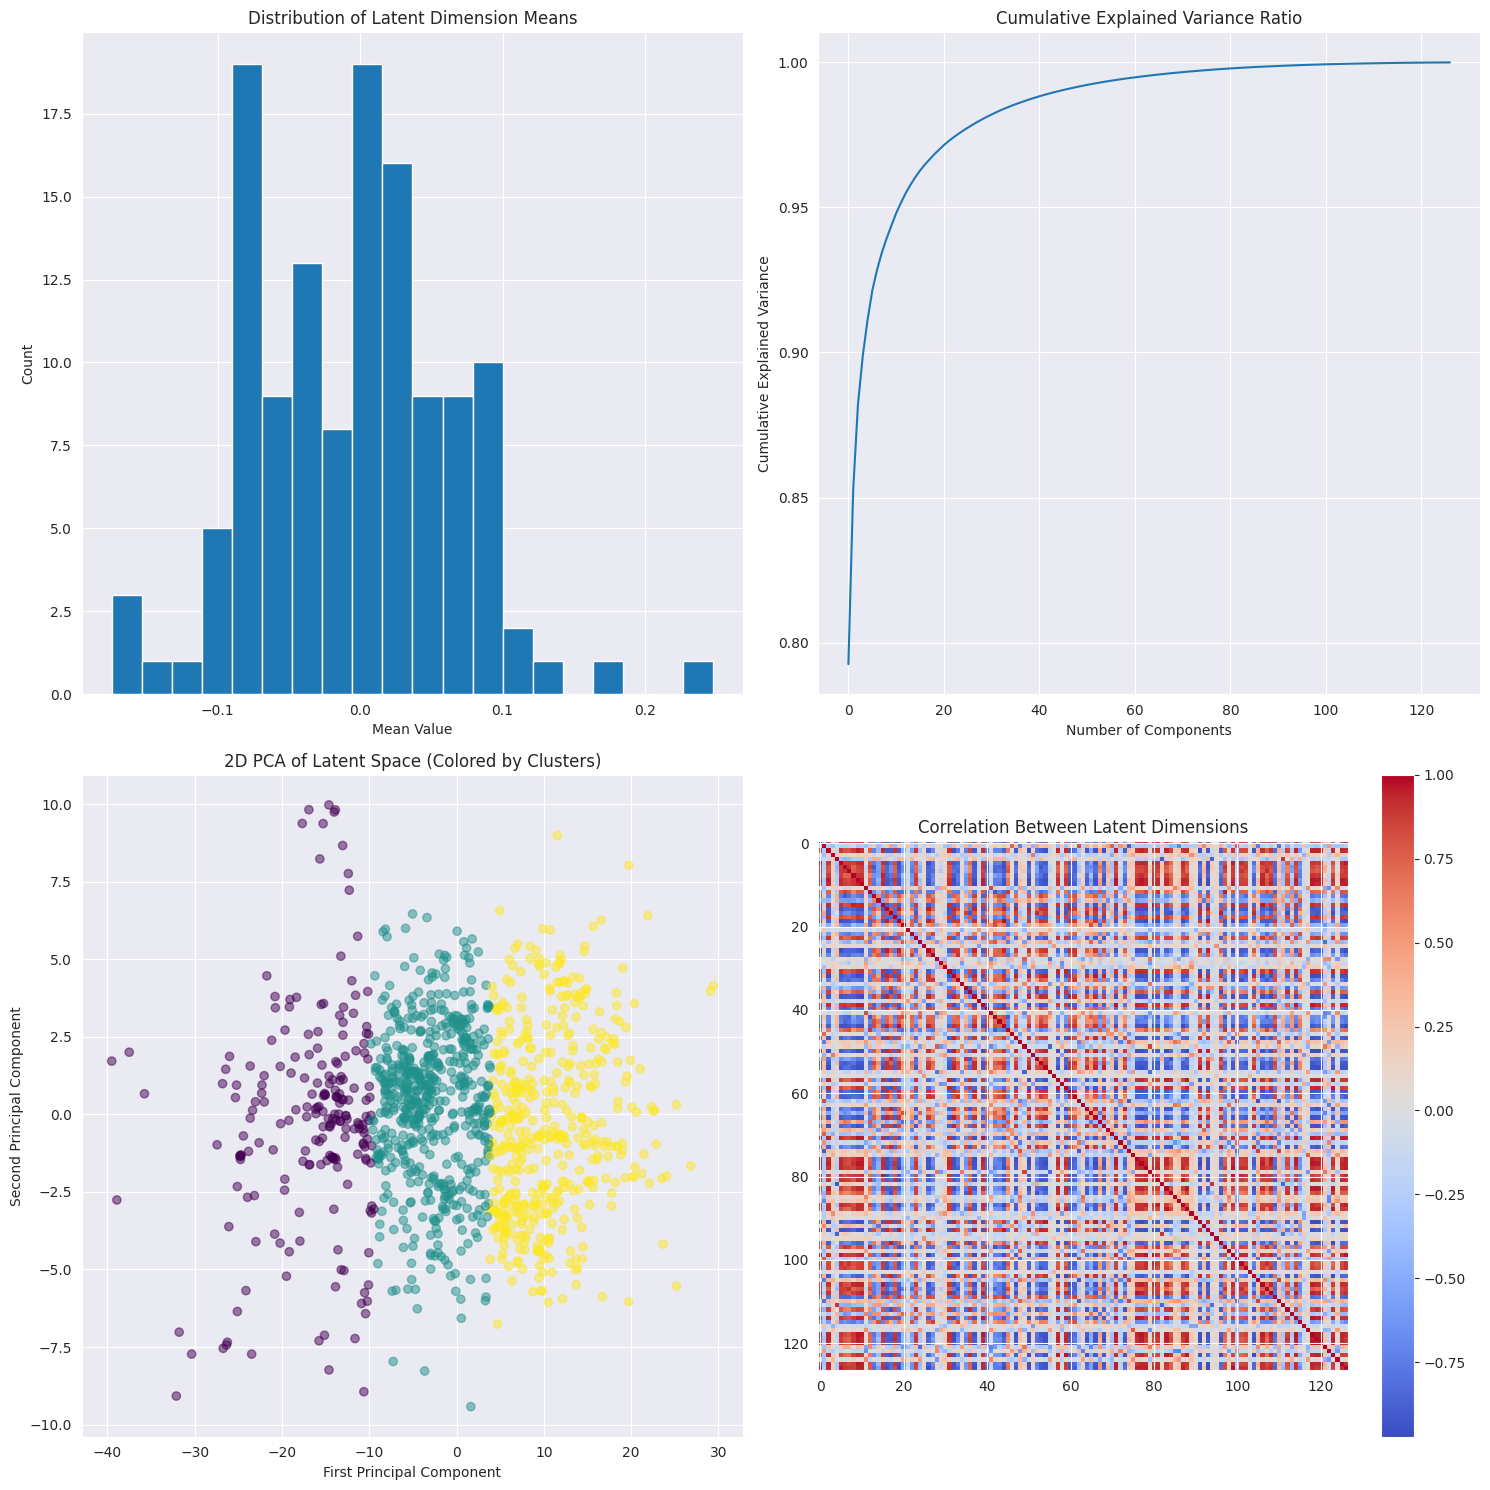

In [28]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


def extract_latent_representations(model, dataloader, device):
    model.eval()
    all_mus = []
    all_actions = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Get inputs
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            # Get actions for analysis
            actions = batch.output["actions"] if "actions" in batch.output else None
            
            # Get latent representations (mu)
            mu, _ = model.encode(x_img, x_num)
            
            # Store results
            all_mus.append(mu.cpu().numpy())
            if actions is not None:
                all_actions.append(actions.cpu().numpy())
    
    # Concatenate all batches
    all_mus = np.concatenate(all_mus, axis=0)
    all_actions = np.concatenate(all_actions, axis=0) if actions is not None else None
    
    return all_mus, all_actions

# Extract latent representations
latent_reps, actions = extract_latent_representations(vae_model, train_dataloader, device)

# Now let's analyze the latent space
def analyze_latent_space_properties(latent_reps):
    """Analyze various properties of the latent space"""
    
    # 1. Distribution Analysis
    mean_per_dim = np.mean(latent_reps, axis=0)
    std_per_dim = np.std(latent_reps, axis=0)
    
    # 2. Dimensionality Analysis
    pca = PCA()
    pca.fit(latent_reps)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 3. Clustering Analysis
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(latent_reps)
    
    # 4. Visualize first two principal components
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_reps)
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot distributions
    axes[0,0].hist(mean_per_dim, bins=20)
    axes[0,0].set_title('Distribution of Latent Dimension Means')
    axes[0,0].set_xlabel('Mean Value')
    axes[0,0].set_ylabel('Count')
    
    # Plot explained variance
    axes[0,1].plot(np.cumsum(explained_variance_ratio))
    axes[0,1].set_title('Cumulative Explained Variance Ratio')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    
    # Plot 2D PCA
    scatter = axes[1,0].scatter(latent_2d[:, 0], latent_2d[:, 1], 
                               c=clusters, cmap='viridis', alpha=0.5)
    axes[1,0].set_title('2D PCA of Latent Space (Colored by Clusters)')
    axes[1,0].set_xlabel('First Principal Component')
    axes[1,0].set_ylabel('Second Principal Component')
    
    # Plot correlation heatmap
    correlation_matrix = np.corrcoef(latent_reps.T)
    im = axes[1,1].imshow(correlation_matrix, cmap='coolwarm')
    axes[1,1].set_title('Correlation Between Latent Dimensions')
    plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mean_per_dim': mean_per_dim,
        'std_per_dim': std_per_dim,
        'explained_variance_ratio': explained_variance_ratio,
        'clusters': clusters
    }

# Run analysis
analysis_results = analyze_latent_space_properties(latent_reps)

def extract_latent_representations(model, dataloader, device):
    model.eval()
    all_mus = []
    all_actions = []
    
    with torch.no_grad():
        for batch in dataloader:
            # Get inputs
            x_img = batch.input["images"].to(device)
            x_num = batch.input["obs"].to(device)
            
            # Get actions for analysis
            actions = batch.output["actions"] if "actions" in batch.output else None
            
            # Get latent representations (mu)
            mu, _ = model.encode(x_img, x_num)
            
            # Store results
            all_mus.append(mu.cpu().numpy())
            if actions is not None:
                all_actions.append(actions.cpu().numpy())
    
    # Concatenate all batches
    all_mus = np.concatenate(all_mus, axis=0)
    all_actions = np.concatenate(all_actions, axis=0) if actions is not None else None
    
    return all_mus, all_actions

# Extract latent representations
latent_reps, actions = extract_latent_representations(vae_model, train_dataloader, device)

# Now let's analyze the latent space
def analyze_latent_space_properties(latent_reps):
    """Analyze various properties of the latent space"""
    
    # 1. Distribution Analysis
    mean_per_dim = np.mean(latent_reps, axis=0)
    std_per_dim = np.std(latent_reps, axis=0)
    
    # 2. Dimensionality Analysis
    pca = PCA()
    pca.fit(latent_reps)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    # 3. Clustering Analysis
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(latent_reps)
    
    # 4. Visualize first two principal components
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_reps)
    
    # Create visualization plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Plot distributions
    axes[0,0].hist(mean_per_dim, bins=20)
    axes[0,0].set_title('Distribution of Latent Dimension Means')
    axes[0,0].set_xlabel('Mean Value')
    axes[0,0].set_ylabel('Count')
    
    # Plot explained variance
    axes[0,1].plot(np.cumsum(explained_variance_ratio))
    axes[0,1].set_title('Cumulative Explained Variance Ratio')
    axes[0,1].set_xlabel('Number of Components')
    axes[0,1].set_ylabel('Cumulative Explained Variance')
    
    # Plot 2D PCA
    scatter = axes[1,0].scatter(latent_2d[:, 0], latent_2d[:, 1], 
                               c=clusters, cmap='viridis', alpha=0.5)
    axes[1,0].set_title('2D PCA of Latent Space (Colored by Clusters)')
    axes[1,0].set_xlabel('First Principal Component')
    axes[1,0].set_ylabel('Second Principal Component')
    
    # Plot correlation heatmap
    correlation_matrix = np.corrcoef(latent_reps.T)
    im = axes[1,1].imshow(correlation_matrix, cmap='coolwarm')
    axes[1,1].set_title('Correlation Between Latent Dimensions')
    plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    # plt.show()
    
    return {
        'mean_per_dim': mean_per_dim,
        'std_per_dim': std_per_dim,
        'explained_variance_ratio': explained_variance_ratio,
        'clusters': clusters
    }

# Run analysis
analysis_results = analyze_latent_space_properties(latent_reps)

$ \text{Latent Space Analysis} $
$ \text{1. PCA of Latent Space: Ideally our latent space should roughly resemble a 2D Normal distribution (that is, a spherical distribution). More than being spherical, our latent space should be smooth, continuous, and free of any big gaps. It should preserve features of the downstreak task.} $

## Question 3 Full model training
This question requires you to first develop a supervised head which utilises the latent space from your self-supervised method. You are then required to assess the models performance as well as the model you developed in question 1.c.i on the test set, report the performance and conclude whether self-supervised learning is appropriate for this task.

### Question 3.a Combining self-supervised model with the downstream task (5 marks)

##### Task
- Develop a model which combines the self-supervised pretraining with a model for performing the downstream task by freezing the self-supervised model and fine-tuning a head for prediction and implement it in the code block below. Markers should be able to retrain your model by running the cell below. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions). The supervised head should at least include any inputs that you did not feed into the self-supervised model. For example, assume you decide to perform self-supervised learning only using front_cam_ob images. You must also include mount_cam_ob, ee_cartesian_pos_ob, ee_cartesian_vel_ob and joint_pos_ob observations in your model.

In [29]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

### Question 3.b Assessing the suitability of self-supervised learning 
For the final two questions, you are required to assess the performance of the self-supervised + supervised head model and the end-to-end model that you have trained. Additionally, you are required to holistically evaluate whether self-supervised learning has been beneficial for this task.

#### Question 3.b.i Assessing the suitability of self-supervised learning (4 marks) 

##### Task
- In the code block below, evaluate the performance of the model you trained in question 3.a and the model you trained in question 1.c.i, using the test set. Additionally use the same metrics to train and evaluate the model that you used for question 1.c.i. Markers should be able to run the cell such that both models are run on the appropriate dataset. You may however, reference previously defined objects (e.g., loaded data and use previously defined functions).

In [30]:
# ******* INSERT YOUR CODE HERE *******


# ******* INSERT YOUR CODE HERE - END *******

#### Question 3.b.ii Justification (5 marks)

##### Task
- Conclude whether the self-supervised pre-training was beneficial for the task of predicting actions. Your answer should not solely focus on final performance but rather be nuianced and balance other model development considerations for example parameter count and speed of convergence. Also, if you believe the comparison between the model trained in question 3.a.i aganst the model trained in question 2.c.i is not _fair_, discuss further experiments which you would perform to reduce the bias in your conclusions. Provide __empirical evidence__ to support your conclusions. __0 marks__ will be awarded if empirical evidence is __not__ provided.